In this notebook we'll try every possible configuration of our C-RNN_GAN.

Firslty, we'll see if using **curriculum learning** does any good or if it's better to just train for a fixed length. After that, and with the best option between curriculum learning and not curriculum learning, we'll try to see if scaling the data does any difference. For that, different scaling possibilities we'll be tried out. From **standard sclaing** (or normalizing from a statistical point of view) to **min-max scaling** going through **percentile scaling**, which is very similar to min-max scaling but instead of choosing the minimum and maximum from the sample data we use percentiles (for example percenitile 2 for the minimum and percentile 90 for the maximum).
Finally, we'll try different complexities for the generator and the discriminator with the best options from the previous experiments (curriculum/not-curriculum learning, scaling/not-scaling, etc).

In [0]:
# Connect to google drive where we store out scripts and our generated songs.
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).




Setup steps needed to be able to use music_data_utils. Basically, installing from source python3-midi, which music_data_utils uses. In order to install python3-midi a module called swig is needed and therefore we install it using the usual linux installer (apt-get).

Finally, to load the music_data_utils script and all the functionalities related to out implementation of C-RNN_GAN, we use the standard python importer.

In [0]:
!git clone https://github.com/louisabraham/python3-midi.git

Cloning into 'python3-midi'...
remote: Enumerating objects: 553, done.
remote: Total 553 (delta 0), reused 0 (delta 0), pack-reused 553
Receiving objects: 100% (553/553), 208.19 KiB | 816.00 KiB/s, done.
Resolving deltas: 100% (314/314), done.


In [0]:
!apt-get install swig -y

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  swig3.0
Suggested packages:
  swig-doc swig-examples swig3.0-examples swig3.0-doc
The following NEW packages will be installed:
  swig swig3.0
0 upgraded, 2 newly installed, 0 to remove and 25 not upgraded.
Need to get 1,100 kB of archives.
After this operation, 5,822 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 swig3.0 amd64 3.0.12-1 [1,094 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 swig amd64 3.0.12-1 [6,460 B]
Fetched 1,100 kB in 0s (9,597 kB/s)
Selecting previously unselected package swig3.0.
(Reading database ... 144568 files and directories currently installed.)
Preparing to unpack .../swig3.0_3.0.12-1_amd64.deb ...
Unpacking swig3.0 (3.0.12-1) ...
Selecting previously unselected package swig.
Preparing to unpack .../swig_3.0.12-1_amd64.deb ...
Unpackin

In [0]:
!cd python3-midi && python setup.py install

/usr/local/lib/python3.6/dist-packages/setuptools/dist.py:454: UserWarning: Normalizing 'v0.2.3' to '0.2.3'
  warnings.warn(tmpl.format(**locals()))
running install
running build_ext
building '_sequencer_alsa' extension
swigging src/sequencer_alsa/sequencer_alsa.i to src/sequencer_alsa/sequencer_alsa_wrap.c
swig -python -I/usr/include -o src/sequencer_alsa/sequencer_alsa_wrap.c src/sequencer_alsa/sequencer_alsa.i
creating build
creating build/temp.linux-x86_64-3.6
creating build/temp.linux-x86_64-3.6/src
creating build/temp.linux-x86_64-3.6/src/sequencer_alsa
x86_64-linux-gnu-gcc -pthread -DNDEBUG -g -fwrapv -O2 -Wall -g -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -fPIC -I/usr/include/python3.6m -c src/sequencer_alsa/sequencer_alsa_wrap.c -o build/temp.linux-x86_64-3.6/src/sequencer_alsa/sequencer_alsa_wrap.o
creating build/lib.linux-x86_64-3.6
creating build/lib.linux-x86_64-3.6/midi
creating build/lib.linux-x86_64-3.6/midi/sequencer
x86_6

In [0]:
import importlib.util

In [0]:
## Import Music Utils
spec = importlib.util.spec_from_file_location("*", "./drive/My Drive/TFM/music_data_utils.py")
music_data_utils = importlib.util.module_from_spec(spec)
spec.loader.exec_module(music_data_utils)

In [0]:
## Import C-RNN-GAN
spec = importlib.util.spec_from_file_location("*", "./drive/My Drive/TFM/crnngan.py")
crnngan = importlib.util.module_from_spec(spec)
spec.loader.exec_module(crnngan)

In [0]:
import torch
import numpy as np
import time
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
# Instantiate the data loader
drive_path_to_music = './drive/My Drive/TFM/music_data'
musicDataLoader = music_data_utils.MusicDataLoader(drive_path_to_music, 0, 0)

Data loader: datadir: ./drive/My Drive/TFM/music_data
num genres:1
num composers: 154
limit works per composer: None
Reading files classical/adam: 3
Reading files classical/aguado: 5
Reading files classical/albenizisaac: 20
Reading files classical/albenizmateo: 2
Reading files classical/albinoni: 1
Reading files classical/alford: 2
Reading files classical/alkan: 11
Reading files classical/anderson: 8
Reading files classical/ansell: 1
Reading files classical/arensky: 5
Reading files classical/arriaga: 2
Reading files classical/bach: 100
Reading files classical/bach: 200
Reading files classical/bach: 300
Reading files classical/bach: 360
Reading files classical/barber: 8
Path does not exist: ./drive/My Drive/TFM/music_data/classical/barbieri
Reading files classical/bartok: 99
Reading files classical/bax: 2
Error reading ./drive/My Drive/TFM/music_data/classical/beethoven/14715thSympnmov1.mid
Reading files classical/beethoven: 68
Reading files classical/bellini: 4
Reading files classical/

In [0]:
import random
# Set random seeds for REPRODUCIBILITY
manualSeed = 0
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  0


## Train C-RNN-GAN without Curriculum learning.

In [0]:
# Data loader
batch_length = 100
sequence_length = 100
# Generator parameters
in_channels_g = 20
out_channels_g = 4
hidden_dim_g = 350
n_layers_g = 2
# Discriminator parameters
in_channels_d = 4
out_channels_d = 2
hidden_dim_d = 350
n_layers_d = 2
# General
epochs = 50
curriculum_learning = False


crnngan_vanilla = crnngan.CRNNGAN(batch_length, sequence_length,
                 in_channels_g, out_channels_g, hidden_dim_g, n_layers_g,
                 in_channels_d, out_channels_d, hidden_dim_d, n_layers_d,
                 curriculum_learning = curriculum_learning, epochs=epochs)

cuda


In [0]:
crnngan_vanilla.trainloop(musicDataLoader)

Start training for 50 epochs
[0/50][0]	Loss_D: 9.2091	Loss_G: 3.4782	D(x): -4.5415	D(G(z)): -4.6046 / -0.0010
 Time since epoch started: 0.36
There are a total of 0 fake songs saved already
[0/50][10]	Loss_D: 0.9054	Loss_G: 3.8508	D(x): -0.5633	D(G(z)): -0.2689 / -0.3118
 Time since epoch started: 1.67
There are a total of 5 fake songs saved already
[0/50][20]	Loss_D: 0.0482	Loss_G: 5.7855	D(x): -0.0407	D(G(z)): -0.0075 / -0.0066
 Time since epoch started: 2.97
There are a total of 10 fake songs saved already
Epoch time: 3.62
[1/50][30]	Loss_D: 0.0101	Loss_G: 6.4815	D(x): -0.0078	D(G(z)): -0.0024 / -0.0020
 Time since epoch started: 0.65
There are a total of 15 fake songs saved already
[1/50][40]	Loss_D: 0.0022	Loss_G: 8.1430	D(x): -0.0016	D(G(z)): -0.0007 / -0.0005
 Time since epoch started: 1.94
There are a total of 20 fake songs saved already
[1/50][50]	Loss_D: 0.0874	Loss_G: 7.2579	D(x): -0.0028	D(G(z)): -0.0234 / -0.0057
 Time since epoch started: 3.25
There are a total of 25 fake

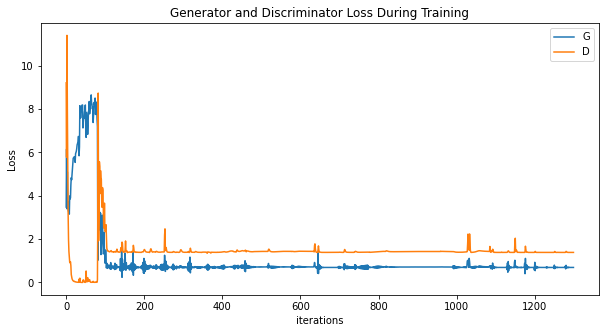

In [0]:
crnngan_vanilla.plot_losses()

In this experiment we've kept all parameters for the discriminator and the generator equal, and as can be seen it reaches convergence around iteration 400.

We'll visualize, save and listen to three fakely generated songs, one around iteration 400, another one around iteration 800 and finally the last generated song.

For comparison purposes we'll visualize a couple real songs.

In [0]:
seq_length = 100
batch_length = 100
musicDataLoader.rewind('train')
_, batch_data = musicDataLoader.get_batch(batchsize=batch_length, songlength=seq_length)

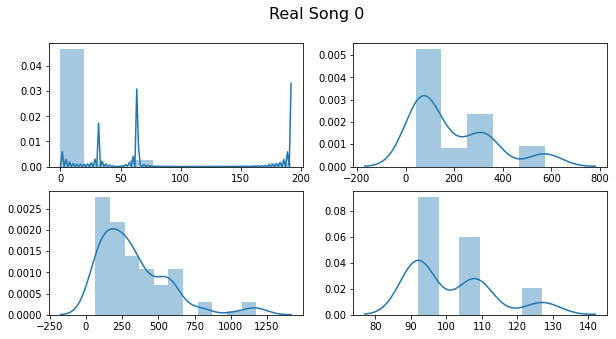

In [0]:
fig, axs = plt.subplots(2, 2, figsize=(10,5))
fig.suptitle('Real Song 0 ', fontsize=16)
sns.distplot(batch_data[0,:,0], ax=axs[0, 0])
sns.distplot(batch_data[0,:,1], ax=axs[0, 1])
sns.distplot(batch_data[0,:,2], ax=axs[1, 0])
sns.distplot(batch_data[0,:,3], ax=axs[1, 1])

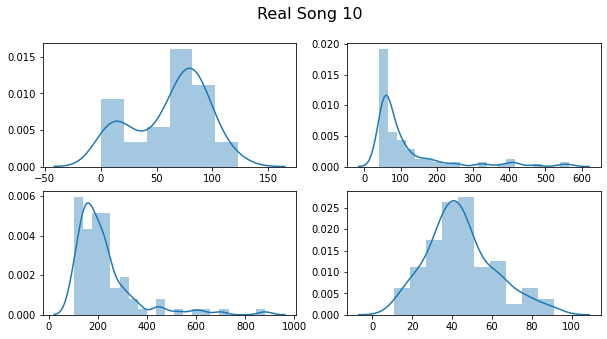

In [0]:
fig, axs = plt.subplots(2, 2, figsize=(10,5))
fig.suptitle('Real Song 10 ', fontsize=16)
sns.distplot(batch_data[10,:,0], ax=axs[0, 0])
sns.distplot(batch_data[10,:,1], ax=axs[0, 1])
sns.distplot(batch_data[10,:,2], ax=axs[1, 0])
sns.distplot(batch_data[10,:,3], ax=axs[1, 1])

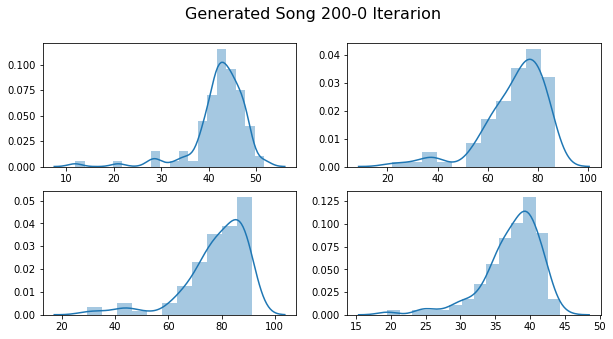

In [0]:
gen_song_200 = crnngan_vanilla.generated_songs[200][0].cpu().numpy()
fig, axs = plt.subplots(2, 2, figsize=(10,5))
fig.suptitle('Generated Song 200-0 Iterarion', fontsize=16)
sns.distplot(gen_song_200[:,0], ax=axs[0, 0])
sns.distplot(gen_song_200[:,1], ax=axs[0, 1])
sns.distplot(gen_song_200[:,2], ax=axs[1, 0])
sns.distplot(gen_song_200[:,3], ax=axs[1, 1])

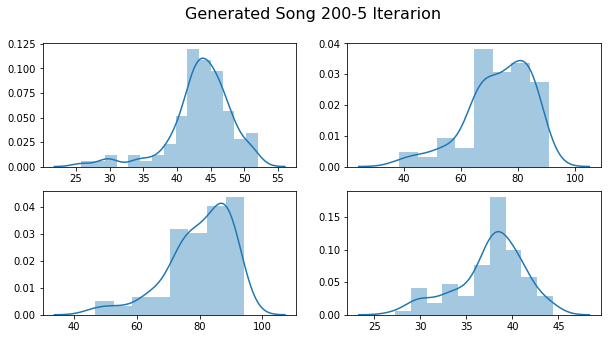

In [0]:
gen_song_200_5 = crnngan_vanilla.generated_songs[200][5].cpu().numpy()
fig, axs = plt.subplots(2, 2, figsize=(10,5))
fig.suptitle('Generated Song 200-5 Iterarion', fontsize=16)
sns.distplot(gen_song_200_5[:,0], ax=axs[0, 0])
sns.distplot(gen_song_200_5[:,1], ax=axs[0, 1])
sns.distplot(gen_song_200_5[:,2], ax=axs[1, 0])
sns.distplot(gen_song_200_5[:,3], ax=axs[1, 1])

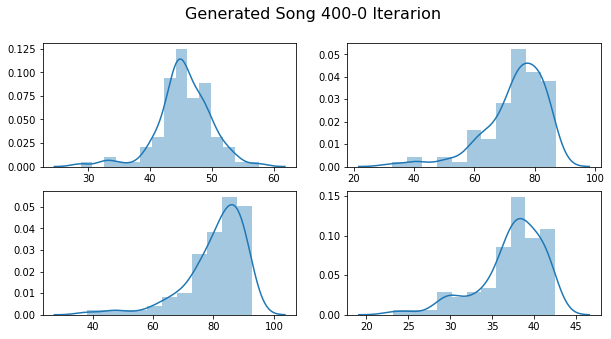

In [0]:
gen_song_400 = crnngan_vanilla.generated_songs[400][0].cpu().numpy()
fig, axs = plt.subplots(2, 2, figsize=(10,5))
fig.suptitle('Generated Song 400-0 Iterarion', fontsize=16)
sns.distplot(gen_song_400[:,0], ax=axs[0, 0])
sns.distplot(gen_song_400[:,1], ax=axs[0, 1])
sns.distplot(gen_song_400[:,2], ax=axs[1, 0])
sns.distplot(gen_song_400[:,3], ax=axs[1, 1])

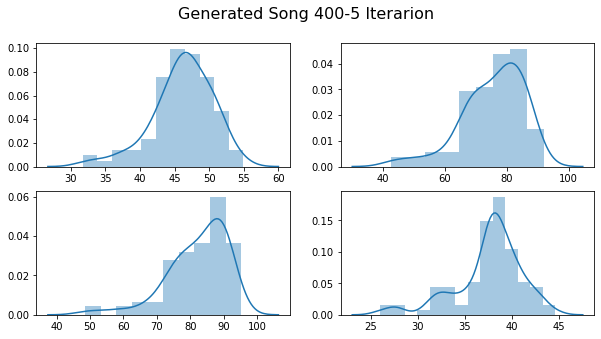

In [0]:
gen_song_400_5 = crnngan_vanilla.generated_songs[400][5].cpu().numpy()
fig, axs = plt.subplots(2, 2, figsize=(10,5))
fig.suptitle('Generated Song 400-5 Iterarion', fontsize=16)
sns.distplot(gen_song_400_5[:,0], ax=axs[0, 0])
sns.distplot(gen_song_400_5[:,1], ax=axs[0, 1])
sns.distplot(gen_song_400_5[:,2], ax=axs[1, 0])
sns.distplot(gen_song_400_5[:,3], ax=axs[1, 1])

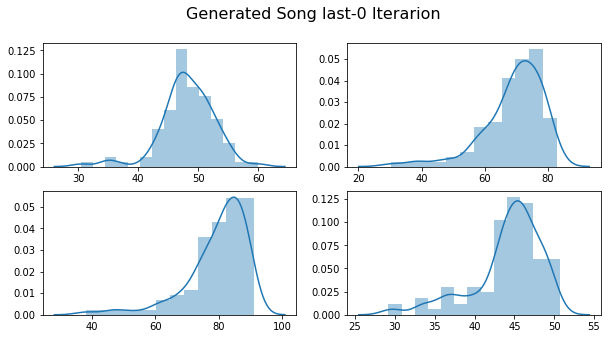

In [0]:
gen_song_last = crnngan_vanilla.generated_songs[-1][0].cpu().numpy()
fig, axs = plt.subplots(2, 2, figsize=(10,5))
fig.suptitle('Generated Song last-0 Iterarion', fontsize=16)
sns.distplot(gen_song_last[:,0], ax=axs[0, 0])
sns.distplot(gen_song_last[:,1], ax=axs[0, 1])
sns.distplot(gen_song_last[:,2], ax=axs[1, 0])
sns.distplot(gen_song_last[:,3], ax=axs[1, 1])

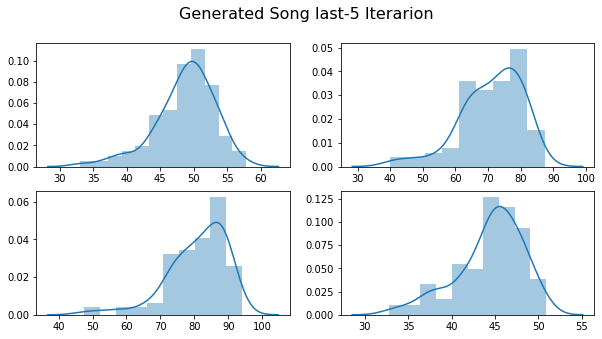

In [0]:
gen_song_last_5 = crnngan_vanilla.generated_songs[-1][5].cpu().numpy()
fig, axs = plt.subplots(2, 2, figsize=(10,5))
fig.suptitle('Generated Song last-5 Iterarion', fontsize=16)
sns.distplot(gen_song_last_5[:,0], ax=axs[0, 0])
sns.distplot(gen_song_last_5[:,1], ax=axs[0, 1])
sns.distplot(gen_song_last_5[:,2], ax=axs[1, 0])
sns.distplot(gen_song_last_5[:,3], ax=axs[1, 1])

It seems like features 2 and 3 of the real songs are positively skewed while for the generated songs those same features are negetively skewed. Also, those two features should have larger values than they do in the generated songs. 

Either way, we see some improvement on training, as the generated distributions look a bit more like the real ones, also we see that the variance is reduced. However, for feature 1 we obtain too low values, and since this variable is related to how the notes are represented in midi format, we end up getting too low songs...

In [0]:
vanilla_save_path = './drive/My Drive/TFM/vanilla_generated_songs'
musicDataLoader.save_data(vanilla_save_path+'/gen_song_200_0.midi', gen_song_200)
musicDataLoader.save_data(vanilla_save_path+'/gen_song_200_5.midi', gen_song_200_5)
musicDataLoader.save_data(vanilla_save_path+'/gen_song_400_0.midi', gen_song_400)
musicDataLoader.save_data(vanilla_save_path+'/gen_song_400_5.midi', gen_song_400_5)
musicDataLoader.save_data(vanilla_save_path+'/gen_song_last_0.midi', gen_song_last)
musicDataLoader.save_data(vanilla_save_path+'/gen_song_last_5.midi', gen_song_last_5)

midi.Pattern(format=1, resolution=384, tracks=\
[midi.Track(\
  [midi.SetTempoEvent(tick=0, data=[20, 88, 85]),
   midi.NoteOnEvent(tick=54, channel=0, data=[41, 50]),
   midi.NoteOnEvent(tick=46, channel=0, data=[40, 46]),
   midi.NoteOffEvent(tick=32, channel=0, data=[41, 0]),
   midi.NoteOnEvent(tick=16, channel=0, data=[41, 46]),
   midi.NoteOffEvent(tick=26, channel=0, data=[40, 0]),
   midi.NoteOnEvent(tick=19, channel=0, data=[38, 35]),
   midi.NoteOffEvent(tick=33, channel=0, data=[41, 0]),
   midi.NoteOnEvent(tick=7, channel=0, data=[38, 45]),
   midi.NoteOffEvent(tick=22, channel=0, data=[38, 0]),
   midi.NoteOnEvent(tick=31, channel=0, data=[40, 51]),
   midi.NoteOffEvent(tick=15, channel=0, data=[38, 0]),
   midi.NoteOnEvent(tick=33, channel=0, data=[41, 48]),
   midi.NoteOffEvent(tick=24, channel=0, data=[40, 0]),
   midi.NoteOnEvent(tick=14, channel=0, data=[37, 38]),
   midi.NoteOffEvent(tick=43, channel=0, data=[41, 0]),
   midi.NoteOnEvent(tick=14, channel=0, data=[40,

After listening to the songs, it seems like each version (200_0/400_0/last_0) is a bit longer in duration than the previous one. This means that one of the variables (the one that measures how often there's a note) is increaing with the training. However, and as expected, we are getting too low values for the notes and hence the generated song is too low.

With the '_5' songs something similar happens, each version is a bit longer but it's still too low.

Something important to note as well is that there's not much difference between the '_0' songs and the '_5' songs, moreover, if there is any difference is bearly noticeable.

## Train a C-RNN-GAN without curriculum learning but a bit more complex.

Here we'll try the following:
- 3 hidden layers in discriminator and generator.

If this version is better than the 2 hidden layers version, we'll keep on trying with 3 layers, otherwise we'll stick to 2.
- Complex generator with specified hidden layers.
- Complex discriminator with specified hidden layers.
- Complex generator and discriminator with specified hidden layers.

In [0]:
# Data loader
batch_length = 100
sequence_length = 100
# Generator parameters
in_channels_g = 20
out_channels_g = 4
hidden_dim_g = 350
n_layers_g = 3
# Discriminator parameters
in_channels_d = 4
out_channels_d = 2
hidden_dim_d = 350
n_layers_d = 3
# General
epochs = 50
curriculum_learning = False

crnngan_vanilla_complex1 = crnngan.CRNNGAN(batch_length, sequence_length,
                 in_channels_g, out_channels_g, hidden_dim_g, n_layers_g,
                 in_channels_d, out_channels_d, hidden_dim_d, n_layers_d,
                 curriculum_learning = curriculum_learning, epochs=epochs)

cuda


In [0]:
crnngan_vanilla_complex1.trainloop(musicDataLoader)

Start training for 50 epochs
[0/50][0]	Loss_D: 9.1929	Loss_G: 3.1040	D(x): -4.5897	D(G(z)): -4.5956 / -0.0689
 Time since epoch started: 0.20
There are a total of 0 fake songs saved already
[0/50][10]	Loss_D: 4.9977	Loss_G: 2.5042	D(x): -0.5236	D(G(z)): -0.5103 / -0.6103
 Time since epoch started: 1.97
There are a total of 5 fake songs saved already
[0/50][20]	Loss_D: 4.6097	Loss_G: 2.2535	D(x): -0.5792	D(G(z)): -0.5769 / -0.6237
 Time since epoch started: 3.74
There are a total of 10 fake songs saved already
Epoch time: 4.62
[1/50][30]	Loss_D: 4.1156	Loss_G: 2.0035	D(x): -0.6660	D(G(z)): -0.6619 / -0.4652
 Time since epoch started: 0.88
There are a total of 15 fake songs saved already
[1/50][40]	Loss_D: 2.7006	Loss_G: 1.0707	D(x): -0.7247	D(G(z)): -0.7513 / -0.7155
 Time since epoch started: 2.65
There are a total of 20 fake songs saved already
[1/50][50]	Loss_D: 2.1085	Loss_G: 1.0062	D(x): -0.6263	D(G(z)): -0.7303 / -0.7324
 Time since epoch started: 4.42
There are a total of 25 fake

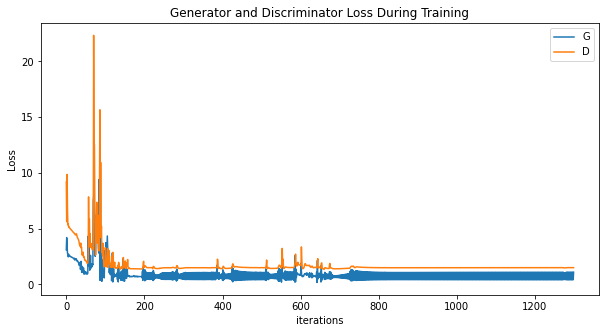

In [0]:
crnngan_vanilla_complex1.plot_losses()

Good convergence. We'll do the same as we did for the previous verison. Visualize and save several generated songs.

In [0]:
seq_length = 100
batch_length = 100
musicDataLoader.rewind('train')
_, batch_data = musicDataLoader.get_batch(batchsize=batch_length, songlength=seq_length)

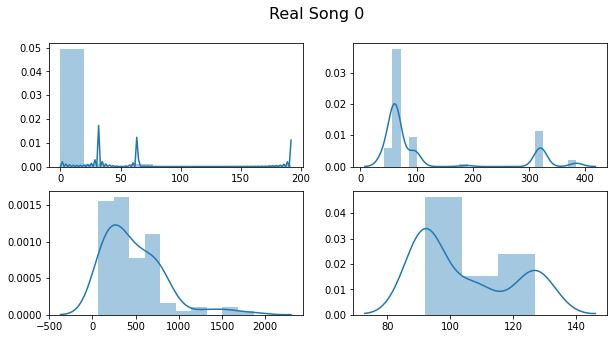

In [0]:
fig, axs = plt.subplots(2, 2, figsize=(10,5))
fig.suptitle('Real Song 0 ', fontsize=16)
sns.distplot(batch_data[0,:,0], ax=axs[0, 0])
sns.distplot(batch_data[0,:,1], ax=axs[0, 1])
sns.distplot(batch_data[0,:,2], ax=axs[1, 0])
sns.distplot(batch_data[0,:,3], ax=axs[1, 1])

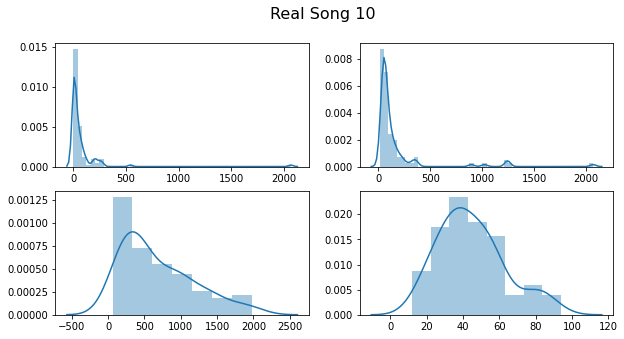

In [0]:
fig, axs = plt.subplots(2, 2, figsize=(10,5))
fig.suptitle('Real Song 10 ', fontsize=16)
sns.distplot(batch_data[10,:,0], ax=axs[0, 0])
sns.distplot(batch_data[10,:,1], ax=axs[0, 1])
sns.distplot(batch_data[10,:,2], ax=axs[1, 0])
sns.distplot(batch_data[10,:,3], ax=axs[1, 1])

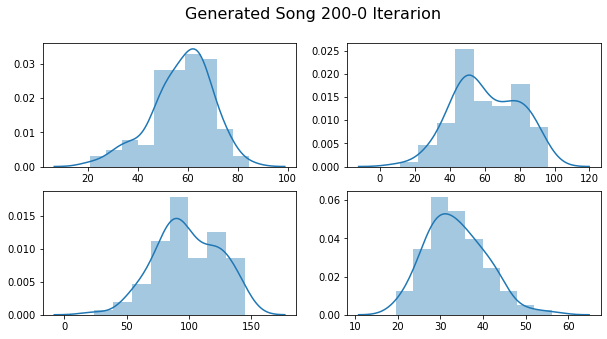

In [0]:
gen_song_complex1_200 = crnngan_vanilla_complex1.generated_songs[200][0].cpu().numpy()
fig, axs = plt.subplots(2, 2, figsize=(10,5))
fig.suptitle('Generated Song 200-0 Iterarion', fontsize=16)
sns.distplot(gen_song_complex1_200[:,0], ax=axs[0, 0])
sns.distplot(gen_song_complex1_200[:,1], ax=axs[0, 1])
sns.distplot(gen_song_complex1_200[:,2], ax=axs[1, 0])
sns.distplot(gen_song_complex1_200[:,3], ax=axs[1, 1])

Just by looking at the distributions we can see that something is wrong as for each variable only two values are being generated...

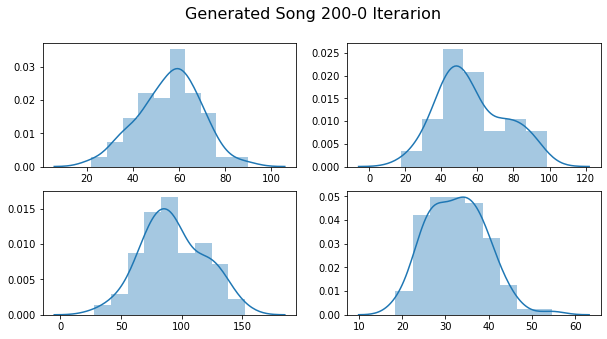

In [0]:
gen_song_complex1_200_5 = crnngan_vanilla_complex1.generated_songs[200][5].cpu().numpy()
fig, axs = plt.subplots(2, 2, figsize=(10,5))
fig.suptitle('Generated Song 200-0 Iterarion', fontsize=16)
sns.distplot(gen_song_complex1_200_5[:,0], ax=axs[0, 0])
sns.distplot(gen_song_complex1_200_5[:,1], ax=axs[0, 1])
sns.distplot(gen_song_complex1_200_5[:,2], ax=axs[1, 0])
sns.distplot(gen_song_complex1_200_5[:,3], ax=axs[1, 1])

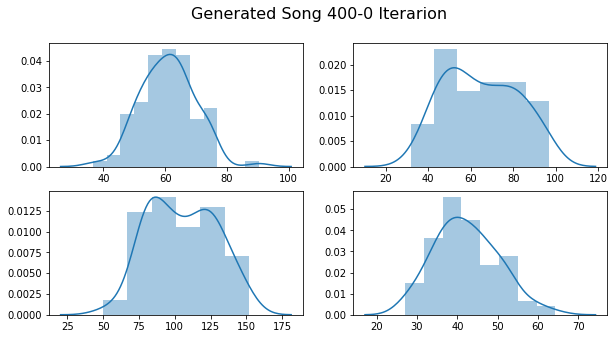

In [0]:
gen_song_complex1_400 = crnngan_vanilla_complex1.generated_songs[400][0].cpu().numpy()
fig, axs = plt.subplots(2, 2, figsize=(10,5))
fig.suptitle('Generated Song 400-0 Iterarion', fontsize=16)
sns.distplot(gen_song_complex1_400[:,0], ax=axs[0, 0])
sns.distplot(gen_song_complex1_400[:,1], ax=axs[0, 1])
sns.distplot(gen_song_complex1_400[:,2], ax=axs[1, 0])
sns.distplot(gen_song_complex1_400[:,3], ax=axs[1, 1])

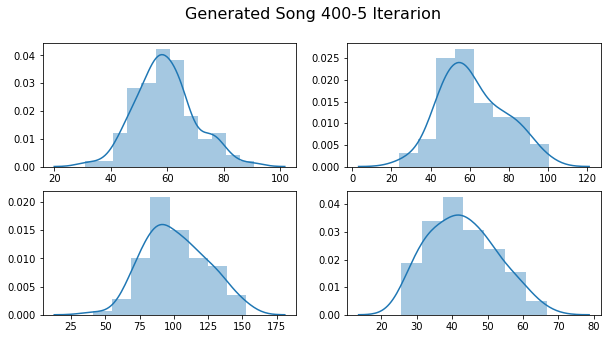

In [0]:
gen_song_complex1_400_5 = crnngan_vanilla_complex1.generated_songs[400][5].cpu().numpy()
fig, axs = plt.subplots(2, 2, figsize=(10,5))
fig.suptitle('Generated Song 400-5 Iterarion', fontsize=16)
sns.distplot(gen_song_complex1_400_5[:,0], ax=axs[0, 0])
sns.distplot(gen_song_complex1_400_5[:,1], ax=axs[0, 1])
sns.distplot(gen_song_complex1_400_5[:,2], ax=axs[1, 0])
sns.distplot(gen_song_complex1_400_5[:,3], ax=axs[1, 1])

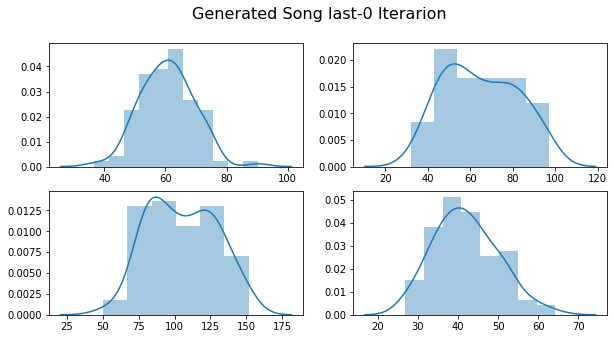

In [0]:
gen_song_complex1_last = crnngan_vanilla_complex1.generated_songs[-1][0].cpu().numpy()
fig, axs = plt.subplots(2, 2, figsize=(10,5))
fig.suptitle('Generated Song last-0 Iterarion', fontsize=16)
sns.distplot(gen_song_complex1_last[:,0], ax=axs[0, 0])
sns.distplot(gen_song_complex1_last[:,1], ax=axs[0, 1])
sns.distplot(gen_song_complex1_last[:,2], ax=axs[1, 0])
sns.distplot(gen_song_complex1_last[:,3], ax=axs[1, 1])

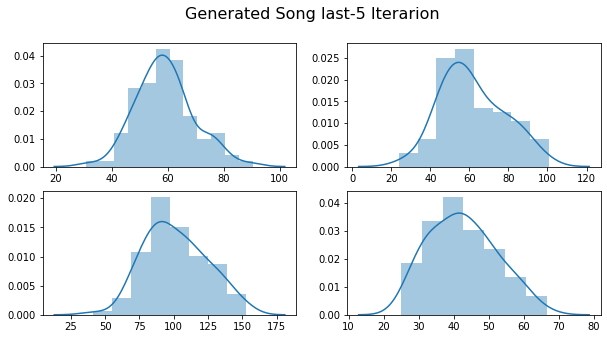

In [0]:
gen_song_complex1_last_5 = crnngan_vanilla_complex1.generated_songs[-1][5].cpu().numpy()
fig, axs = plt.subplots(2, 2, figsize=(10,5))
fig.suptitle('Generated Song last-5 Iterarion', fontsize=16)
sns.distplot(gen_song_complex1_last_5[:,0], ax=axs[0, 0])
sns.distplot(gen_song_complex1_last_5[:,1], ax=axs[0, 1])
sns.distplot(gen_song_complex1_last_5[:,2], ax=axs[1, 0])
sns.distplot(gen_song_complex1_last_5[:,3], ax=axs[1, 1])

These distributions look OK, just as good or as bad as the ones obtained with 2 hidden layers. Maybe variables 2 and 3 look a bit better as their values seem to be a bit larger. 

We'll save these songs and take a listen.

In [0]:
save_path = './drive/My Drive/TFM/vanilla_complex1_generated_songs'
musicDataLoader.save_data(save_path+'/gen_song_complex1_200_0.midi', gen_song_complex1_200)
musicDataLoader.save_data(save_path+'/gen_song_complex1_200_5.midi', gen_song_complex1_200_5)
musicDataLoader.save_data(save_path+'/gen_song_complex1_400_0.midi', gen_song_complex1_400)
musicDataLoader.save_data(save_path+'/gen_song_complex1_400_5.midi', gen_song_complex1_400_5)
musicDataLoader.save_data(save_path+'/gen_song_complex1_last_0.midi', gen_song_complex1_last)
musicDataLoader.save_data(save_path+'/gen_song_complex1_last_5.midi', gen_song_complex1_last_5)

midi.Pattern(format=1, resolution=384, tracks=\
[midi.Track(\
  [midi.SetTempoEvent(tick=0, data=[20, 88, 85]),
   midi.NoteOnEvent(tick=57, channel=0, data=[42, 34]),
   midi.NoteOffEvent(tick=56, channel=0, data=[42, 0]),
   midi.NoteOnEvent(tick=2, channel=0, data=[44, 33]),
   midi.NoteOffEvent(tick=65, channel=0, data=[44, 0]),
   midi.NoteOnEvent(tick=19, channel=0, data=[50, 48]),
   midi.NoteOnEvent(tick=55, channel=0, data=[38, 34]),
   midi.NoteOffEvent(tick=43, channel=0, data=[50, 0]),
   midi.NoteOffEvent(tick=2, channel=0, data=[38, 0]),
   midi.NoteOnEvent(tick=22, channel=0, data=[46, 35]),
   midi.NoteOnEvent(tick=52, channel=0, data=[44, 43]),
   midi.NoteOffEvent(tick=26, channel=0, data=[46, 0]),
   midi.NoteOffEvent(tick=39, channel=0, data=[44, 0]),
   midi.NoteOnEvent(tick=25, channel=0, data=[50, 58]),
   midi.NoteOnEvent(tick=58, channel=0, data=[44, 53]),
   midi.NoteOffEvent(tick=34, channel=0, data=[50, 0]),
   midi.NoteOnEvent(tick=9, channel=0, data=[35, 3

It still sounds a bit too low, however, we've been able to reach some higher notes than before. Also, we keep on seeing the increase in length related to the iteration in which the song was generated.

Moreover, visually, the songs look different and sound a bit different (here is noticeable whereas before it wasn't). However, the difference is less noticeable between the last two generated songs (400 vs last).

**Complex Generator (2 hidden layers everywhere)**

In [0]:
# Data loader
batch_length = 100
sequence_length = 100
# Generator parameters
in_channels_g = 20
out_channels_g = 4
hidden_dim_g = 350
n_layers_g = 2
# Discriminator parameters
in_channels_d = 4
out_channels_d = 2
hidden_dim_d = 350
n_layers_d = 2
# General
epochs = 50
curriculum_learning = False
complexGenerator = True

crnngan_vanilla_complex_generator = crnngan.CRNNGAN(batch_length, sequence_length,
                 in_channels_g, out_channels_g, hidden_dim_g, n_layers_g,
                 in_channels_d, out_channels_d, hidden_dim_d, n_layers_d,
                 curriculum_learning = curriculum_learning, epochs=epochs,
                 complexGenerator=complexGenerator)

cuda
Complex Generator


In [0]:
crnngan_vanilla_complex_generator.trainloop(musicDataLoader)

Start training for 50 epochs
[0/50][0]	Loss_D: 9.2355	Loss_G: 9.2148	D(x): -4.5498	D(G(z)): -4.6028 / -2.8602
 Time since epoch started: 0.15
There are a total of 0 fake songs saved already
[0/50][10]	Loss_D: 2.0669	Loss_G: 5.4612	D(x): -1.0590	D(G(z)): -0.5428 / -0.6058
 Time since epoch started: 1.49
There are a total of 5 fake songs saved already
[0/50][20]	Loss_D: 2.1191	Loss_G: 5.9788	D(x): -1.3276	D(G(z)): -0.4293 / -0.2636
 Time since epoch started: 2.83
There are a total of 10 fake songs saved already
Epoch time: 3.50
[1/50][30]	Loss_D: 1.3893	Loss_G: 8.6045	D(x): -0.4778	D(G(z)): -0.0568 / -0.0345
 Time since epoch started: 0.67
There are a total of 15 fake songs saved already
[1/50][40]	Loss_D: 8.4219	Loss_G: 8.8412	D(x): -2.1248	D(G(z)): -1.0331 / -0.0017
 Time since epoch started: 2.01
There are a total of 20 fake songs saved already
[1/50][50]	Loss_D: 1.8504	Loss_G: 3.3021	D(x): -0.7713	D(G(z)): -0.4313 / -0.0706
 Time since epoch started: 3.34
There are a total of 25 fake

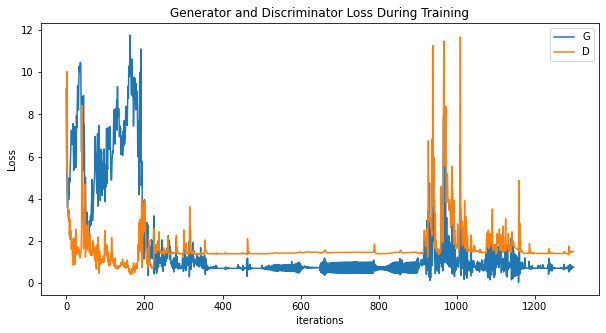

In [0]:
crnngan_vanilla_complex_generator.plot_losses()

Convergence looks about right. Let's see how the generated song look like.

In [0]:
seq_length = 100
batch_length = 100
musicDataLoader.rewind('train')
_, batch_data = musicDataLoader.get_batch(batchsize=batch_length, songlength=seq_length)

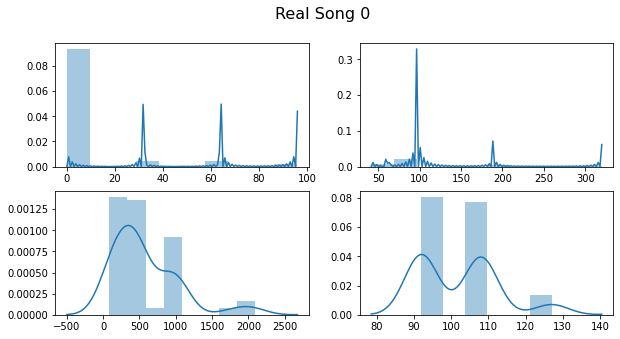

In [0]:
fig, axs = plt.subplots(2, 2, figsize=(10,5))
fig.suptitle('Real Song 0 ', fontsize=16)
sns.distplot(batch_data[0,:,0], ax=axs[0, 0])
sns.distplot(batch_data[0,:,1], ax=axs[0, 1])
sns.distplot(batch_data[0,:,2], ax=axs[1, 0])
sns.distplot(batch_data[0,:,3], ax=axs[1, 1])

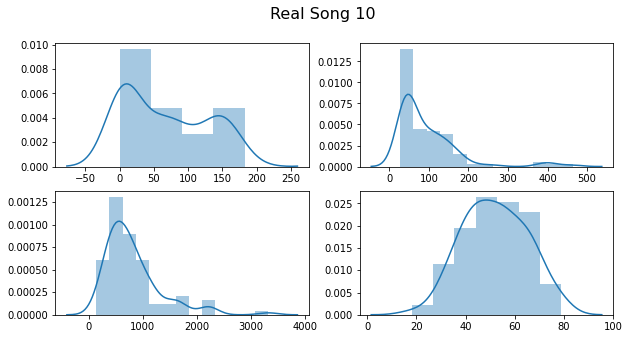

In [0]:
fig, axs = plt.subplots(2, 2, figsize=(10,5))
fig.suptitle('Real Song 10 ', fontsize=16)
sns.distplot(batch_data[10,:,0], ax=axs[0, 0])
sns.distplot(batch_data[10,:,1], ax=axs[0, 1])
sns.distplot(batch_data[10,:,2], ax=axs[1, 0])
sns.distplot(batch_data[10,:,3], ax=axs[1, 1])

It happens very often that there are lot's of 0 values in the first variable, which probably means that no note is played. Also, there seems like there are several heaps in the first variable which we don't seem to get quite right...

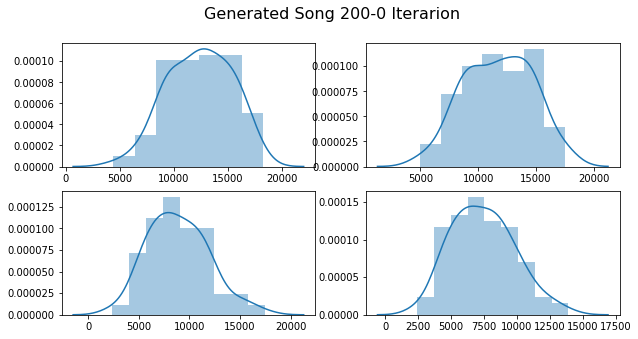

In [0]:
gen_song_complex_generator_200 = crnngan_vanilla_complex_generator.generated_songs[200][0].cpu().numpy()
fig, axs = plt.subplots(2, 2, figsize=(10,5))
fig.suptitle('Generated Song 200-0 Iterarion', fontsize=16)
sns.distplot(gen_song_complex_generator_200[:,0], ax=axs[0, 0])
sns.distplot(gen_song_complex_generator_200[:,1], ax=axs[0, 1])
sns.distplot(gen_song_complex_generator_200[:,2], ax=axs[1, 0])
sns.distplot(gen_song_complex_generator_200[:,3], ax=axs[1, 1])

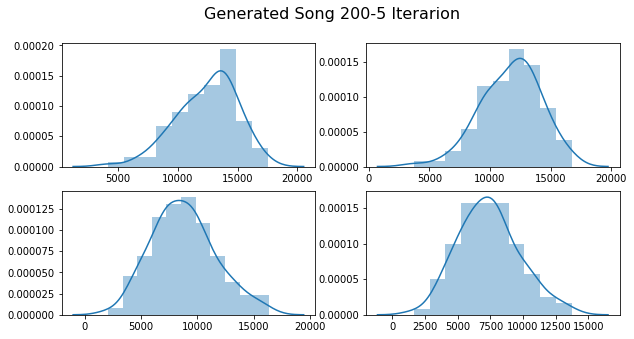

In [0]:
gen_song_complex_generator_200_5 = crnngan_vanilla_complex_generator.generated_songs[200][5].cpu().numpy()
fig, axs = plt.subplots(2, 2, figsize=(10,5))
fig.suptitle('Generated Song 200-5 Iterarion', fontsize=16)
sns.distplot(gen_song_complex_generator_200_5[:,0], ax=axs[0, 0])
sns.distplot(gen_song_complex_generator_200_5[:,1], ax=axs[0, 1])
sns.distplot(gen_song_complex_generator_200_5[:,2], ax=axs[1, 0])
sns.distplot(gen_song_complex_generator_200_5[:,3], ax=axs[1, 1])

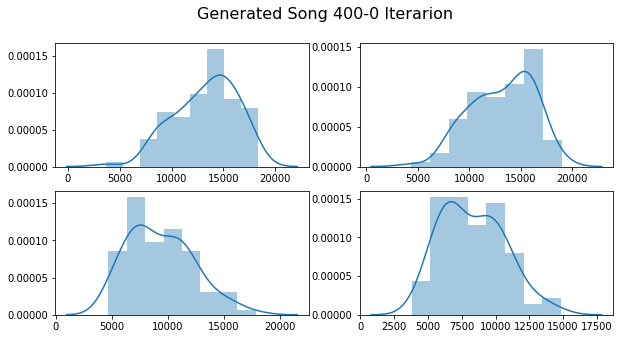

In [0]:
gen_song_complex_generator_400 = crnngan_vanilla_complex_generator.generated_songs[400][0].cpu().numpy()
fig, axs = plt.subplots(2, 2, figsize=(10,5))
fig.suptitle('Generated Song 400-0 Iterarion', fontsize=16)
sns.distplot(gen_song_complex_generator_400[:,0], ax=axs[0, 0])
sns.distplot(gen_song_complex_generator_400[:,1], ax=axs[0, 1])
sns.distplot(gen_song_complex_generator_400[:,2], ax=axs[1, 0])
sns.distplot(gen_song_complex_generator_400[:,3], ax=axs[1, 1])

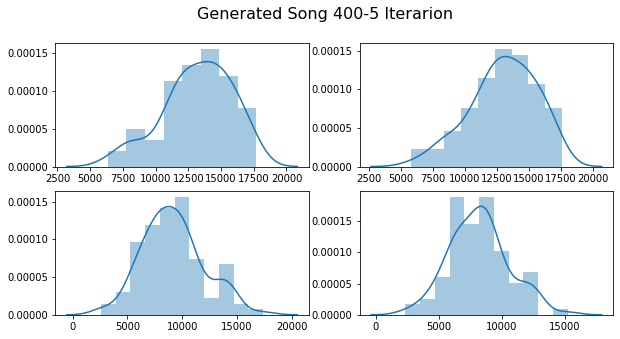

In [0]:
gen_song_complex_generator_400_5 = crnngan_vanilla_complex_generator.generated_songs[400][5].cpu().numpy()
fig, axs = plt.subplots(2, 2, figsize=(10,5))
fig.suptitle('Generated Song 400-5 Iterarion', fontsize=16)
sns.distplot(gen_song_complex_generator_400_5[:,0], ax=axs[0, 0])
sns.distplot(gen_song_complex_generator_400_5[:,1], ax=axs[0, 1])
sns.distplot(gen_song_complex_generator_400_5[:,2], ax=axs[1, 0])
sns.distplot(gen_song_complex_generator_400_5[:,3], ax=axs[1, 1])

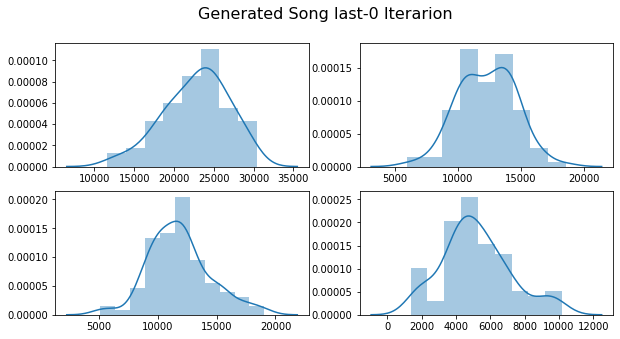

In [0]:
gen_song_complex_generator_last = crnngan_vanilla_complex_generator.generated_songs[-1][0].cpu().numpy()
fig, axs = plt.subplots(2, 2, figsize=(10,5))
fig.suptitle('Generated Song last-0 Iterarion', fontsize=16)
sns.distplot(gen_song_complex_generator_last[:,0], ax=axs[0, 0])
sns.distplot(gen_song_complex_generator_last[:,1], ax=axs[0, 1])
sns.distplot(gen_song_complex_generator_last[:,2], ax=axs[1, 0])
sns.distplot(gen_song_complex_generator_last[:,3], ax=axs[1, 1])

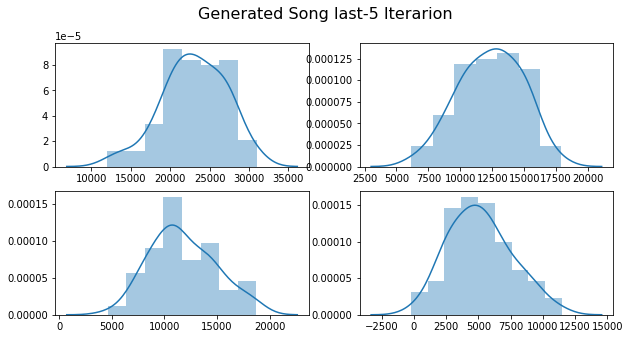

In [0]:
gen_song_complex_generator_last_5 = crnngan_vanilla_complex_generator.generated_songs[-1][5].cpu().numpy()
fig, axs = plt.subplots(2, 2, figsize=(10,5))
fig.suptitle('Generated Song last-5 Iterarion', fontsize=16)
sns.distplot(gen_song_complex_generator_last_5[:,0], ax=axs[0, 0])
sns.distplot(gen_song_complex_generator_last_5[:,1], ax=axs[0, 1])
sns.distplot(gen_song_complex_generator_last_5[:,2], ax=axs[1, 0])
sns.distplot(gen_song_complex_generator_last_5[:,3], ax=axs[1, 1])

We seem to be getting huge values... 

We'll try to add **more complexity to the discriminator** to see if that way we improve the results.

In [0]:
# Data loader
batch_length = 100
sequence_length = 100
# Generator parameters
in_channels_g = 20
out_channels_g = 4
hidden_dim_g = 350
n_layers_g = 2
# Discriminator parameters
in_channels_d = 4
out_channels_d = 2
hidden_dim_d = 350
n_layers_d = 3
# General
epochs = 50
curriculum_learning = False
complexGenerator = True

crnngan_vanilla_complex_generator_balanced = crnngan.CRNNGAN(batch_length, sequence_length,
                 in_channels_g, out_channels_g, hidden_dim_g, n_layers_g,
                 in_channels_d, out_channels_d, hidden_dim_d, n_layers_d,
                 curriculum_learning = curriculum_learning, epochs=epochs,
                 complexGenerator=complexGenerator)

cuda
Complex Generator


In [0]:
crnngan_vanilla_complex_generator_balanced.trainloop(musicDataLoader)

Start training for 50 epochs
[0/50][0]	Loss_D: 9.1990	Loss_G: 3.0394	D(x): -4.5879	D(G(z)): -4.6009 / -0.0710
 Time since epoch started: 0.18
There are a total of 0 fake songs saved already
[0/50][10]	Loss_D: 5.3235	Loss_G: 2.7300	D(x): -0.3747	D(G(z)): -0.3747 / -0.6576
 Time since epoch started: 1.81
There are a total of 5 fake songs saved already
[0/50][20]	Loss_D: 5.0063	Loss_G: 2.2927	D(x): -0.6647	D(G(z)): -0.6647 / -0.4304
 Time since epoch started: 3.44
There are a total of 10 fake songs saved already
Epoch time: 4.25
[1/50][30]	Loss_D: 4.7920	Loss_G: 2.1648	D(x): -0.5699	D(G(z)): -0.5699 / -0.5963
 Time since epoch started: 0.81
There are a total of 15 fake songs saved already
[1/50][40]	Loss_D: 4.6453	Loss_G: 2.0119	D(x): -0.6112	D(G(z)): -0.6112 / -0.6033
 Time since epoch started: 2.45
There are a total of 20 fake songs saved already
[1/50][50]	Loss_D: 4.5704	Loss_G: 1.8443	D(x): -0.4983	D(G(z)): -0.4983 / -0.7766
 Time since epoch started: 4.08
There are a total of 25 fake

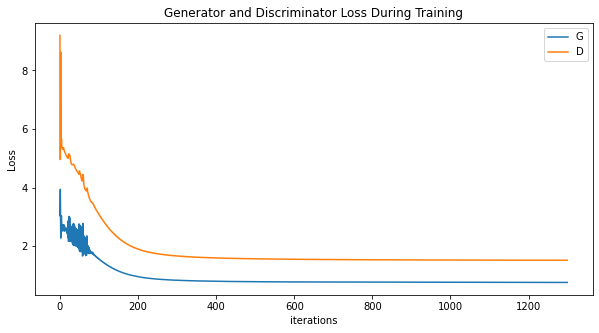

In [0]:
crnngan_vanilla_complex_generator_balanced.plot_losses()

In [0]:
seq_length = 100
batch_length = 100
musicDataLoader.rewind('train')
_, batch_data = musicDataLoader.get_batch(batchsize=batch_length, songlength=seq_length)

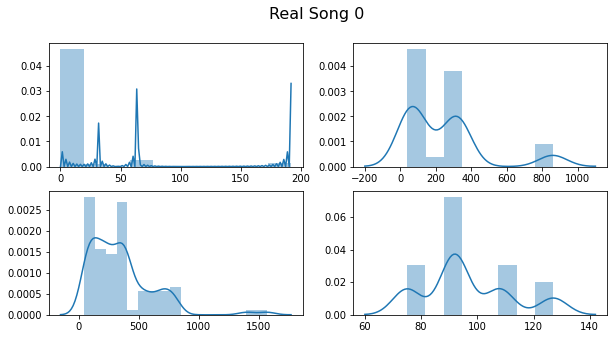

In [0]:
fig, axs = plt.subplots(2, 2, figsize=(10,5))
fig.suptitle('Real Song 0 ', fontsize=16)
sns.distplot(batch_data[0,:,0], ax=axs[0, 0])
sns.distplot(batch_data[0,:,1], ax=axs[0, 1])
sns.distplot(batch_data[0,:,2], ax=axs[1, 0])
sns.distplot(batch_data[0,:,3], ax=axs[1, 1])

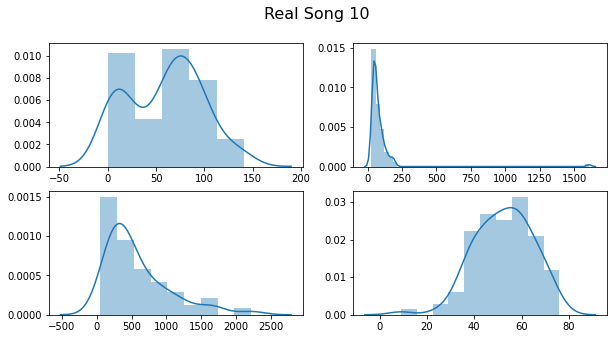

In [0]:
fig, axs = plt.subplots(2, 2, figsize=(10,5))
fig.suptitle('Real Song 10 ', fontsize=16)
sns.distplot(batch_data[10,:,0], ax=axs[0, 0])
sns.distplot(batch_data[10,:,1], ax=axs[0, 1])
sns.distplot(batch_data[10,:,2], ax=axs[1, 0])
sns.distplot(batch_data[10,:,3], ax=axs[1, 1])

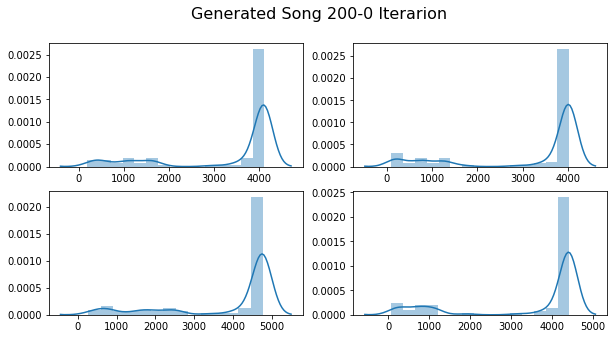

In [0]:
gen_song_complex_generator_200_balanced = crnngan_vanilla_complex_generator_balanced.generated_songs[200][0].cpu().numpy()
fig, axs = plt.subplots(2, 2, figsize=(10,5))
fig.suptitle('Generated Song 200-0 Iterarion', fontsize=16)
sns.distplot(gen_song_complex_generator_200_balanced[:,0], ax=axs[0, 0])
sns.distplot(gen_song_complex_generator_200_balanced[:,1], ax=axs[0, 1])
sns.distplot(gen_song_complex_generator_200_balanced[:,2], ax=axs[1, 0])
sns.distplot(gen_song_complex_generator_200_balanced[:,3], ax=axs[1, 1])

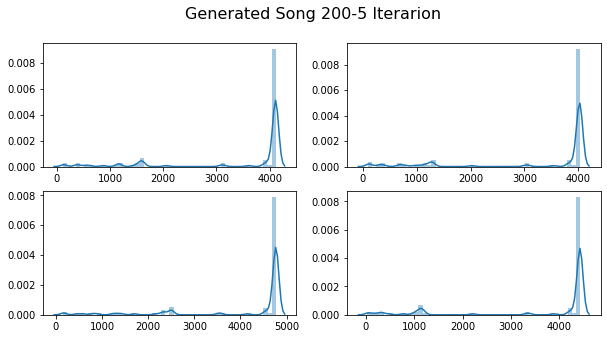

In [0]:
gen_song_complex_generator_200_5_balanced = crnngan_vanilla_complex_generator_balanced.generated_songs[200][5].cpu().numpy()
fig, axs = plt.subplots(2, 2, figsize=(10,5))
fig.suptitle('Generated Song 200-5 Iterarion', fontsize=16)
sns.distplot(gen_song_complex_generator_200_5_balanced[:,0], ax=axs[0, 0])
sns.distplot(gen_song_complex_generator_200_5_balanced[:,1], ax=axs[0, 1])
sns.distplot(gen_song_complex_generator_200_5_balanced[:,2], ax=axs[1, 0])
sns.distplot(gen_song_complex_generator_200_5_balanced[:,3], ax=axs[1, 1])

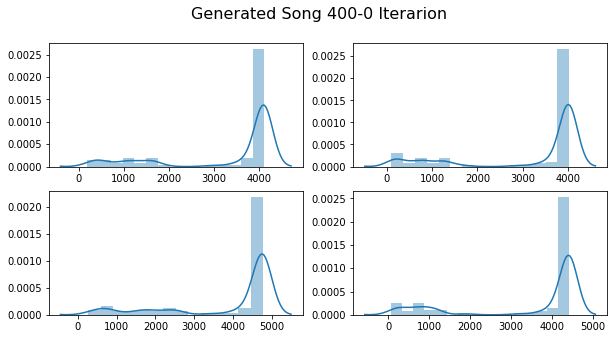

In [0]:
gen_song_complex_generator_400_balanced = crnngan_vanilla_complex_generator_balanced.generated_songs[400][0].cpu().numpy()
fig, axs = plt.subplots(2, 2, figsize=(10,5))
fig.suptitle('Generated Song 400-0 Iterarion', fontsize=16)
sns.distplot(gen_song_complex_generator_400_balanced[:,0], ax=axs[0, 0])
sns.distplot(gen_song_complex_generator_400_balanced[:,1], ax=axs[0, 1])
sns.distplot(gen_song_complex_generator_400_balanced[:,2], ax=axs[1, 0])
sns.distplot(gen_song_complex_generator_400_balanced[:,3], ax=axs[1, 1])

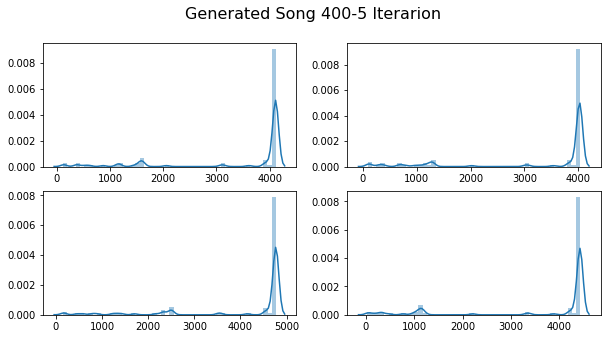

In [0]:
gen_song_complex_generator_400_5_balanced = crnngan_vanilla_complex_generator_balanced.generated_songs[400][5].cpu().numpy()
fig, axs = plt.subplots(2, 2, figsize=(10,5))
fig.suptitle('Generated Song 400-5 Iterarion', fontsize=16)
sns.distplot(gen_song_complex_generator_400_5_balanced[:,0], ax=axs[0, 0])
sns.distplot(gen_song_complex_generator_400_5_balanced[:,1], ax=axs[0, 1])
sns.distplot(gen_song_complex_generator_400_5_balanced[:,2], ax=axs[1, 0])
sns.distplot(gen_song_complex_generator_400_5_balanced[:,3], ax=axs[1, 1])

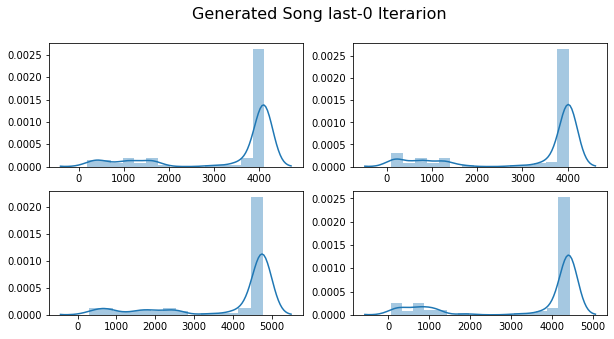

In [0]:
gen_song_complex_generator_last_balanced = crnngan_vanilla_complex_generator_balanced.generated_songs[-1][0].cpu().numpy()
fig, axs = plt.subplots(2, 2, figsize=(10,5))
fig.suptitle('Generated Song last-0 Iterarion', fontsize=16)
sns.distplot(gen_song_complex_generator_last_balanced[:,0], ax=axs[0, 0])
sns.distplot(gen_song_complex_generator_last_balanced[:,1], ax=axs[0, 1])
sns.distplot(gen_song_complex_generator_last_balanced[:,2], ax=axs[1, 0])
sns.distplot(gen_song_complex_generator_last_balanced[:,3], ax=axs[1, 1])

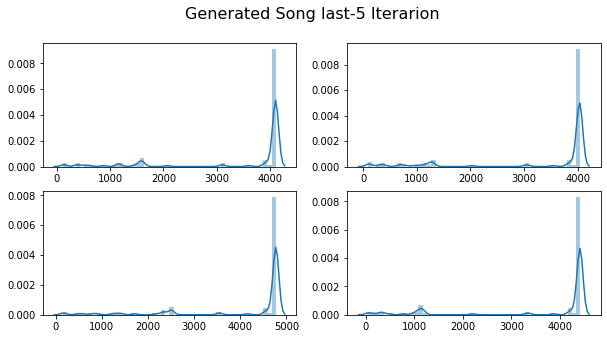

In [0]:
gen_song_complex_generator_last_5_balanced = crnngan_vanilla_complex_generator_balanced.generated_songs[-1][5].cpu().numpy()
fig, axs = plt.subplots(2, 2, figsize=(10,5))
fig.suptitle('Generated Song last-5 Iterarion', fontsize=16)
sns.distplot(gen_song_complex_generator_last_5_balanced[:,0], ax=axs[0, 0])
sns.distplot(gen_song_complex_generator_last_5_balanced[:,1], ax=axs[0, 1])
sns.distplot(gen_song_complex_generator_last_5_balanced[:,2], ax=axs[1, 0])
sns.distplot(gen_song_complex_generator_last_5_balanced[:,3], ax=axs[1, 1])

We keep on getting too large values... We'll try one more configuration, setting the number of hidden layers of the genrator to 3.

In [0]:
# Data loader
batch_length = 100
sequence_length = 100
# Generator parameters
in_channels_g = 20
out_channels_g = 4
hidden_dim_g = 350
n_layers_g = 3
# Discriminator parameters
in_channels_d = 4
out_channels_d = 2
hidden_dim_d = 350
n_layers_d = 3
# General
epochs = 50
curriculum_learning = False
complexGenerator = True

crnngan_vanilla_complex_generator_deep = crnngan.CRNNGAN(batch_length, sequence_length,
                 in_channels_g, out_channels_g, hidden_dim_g, n_layers_g,
                 in_channels_d, out_channels_d, hidden_dim_d, n_layers_d,
                 curriculum_learning = curriculum_learning, epochs=epochs,
                 complexGenerator=complexGenerator)

cuda
Complex Generator


In [0]:
crnngan_vanilla_complex_generator_deep.trainloop(musicDataLoader)

Start training for 50 epochs
[0/50][0]	Loss_D: 9.2069	Loss_G: 3.6514	D(x): -4.5883	D(G(z)): -4.6034 / -0.0151
 Time since epoch started: 0.19
There are a total of 0 fake songs saved already
[0/50][10]	Loss_D: 5.0344	Loss_G: 2.4433	D(x): -0.5246	D(G(z)): -0.5248 / -0.6434
 Time since epoch started: 2.00
There are a total of 5 fake songs saved already
[0/50][20]	Loss_D: 4.8663	Loss_G: 2.4856	D(x): -0.2889	D(G(z)): -0.2889 / -1.1466
 Time since epoch started: 3.79
There are a total of 10 fake songs saved already
Epoch time: 4.69
[1/50][30]	Loss_D: 4.4393	Loss_G: 2.2181	D(x): -0.3271	D(G(z)): -0.3271 / -0.9865
 Time since epoch started: 0.90
There are a total of 15 fake songs saved already
[1/50][40]	Loss_D: 4.1013	Loss_G: 2.0036	D(x): -0.3241	D(G(z)): -0.3241 / -0.9364
 Time since epoch started: 2.71
There are a total of 20 fake songs saved already
[1/50][50]	Loss_D: 3.7862	Loss_G: 1.8399	D(x): -0.3171	D(G(z)): -0.3171 / -0.9462
 Time since epoch started: 4.50
There are a total of 25 fake

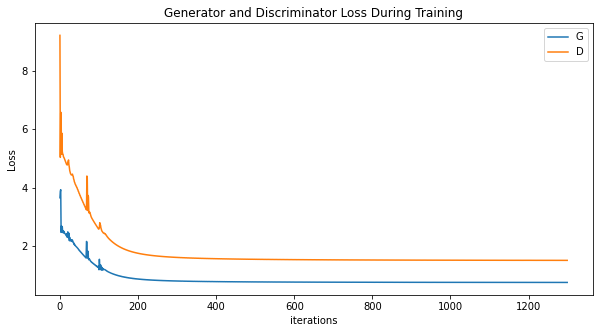

In [0]:
crnngan_vanilla_complex_generator_deep.plot_losses()

In [0]:
seq_length = 100
batch_length = 100
musicDataLoader.rewind('train')
_, batch_data = musicDataLoader.get_batch(batchsize=batch_length, songlength=seq_length)

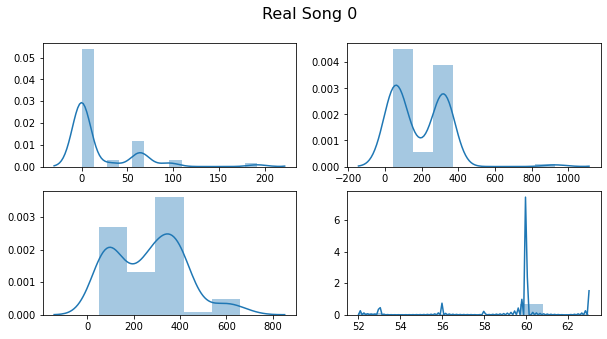

In [0]:
fig, axs = plt.subplots(2, 2, figsize=(10,5))
fig.suptitle('Real Song 0 ', fontsize=16)
sns.distplot(batch_data[0,:,0], ax=axs[0, 0])
sns.distplot(batch_data[0,:,1], ax=axs[0, 1])
sns.distplot(batch_data[0,:,2], ax=axs[1, 0])
sns.distplot(batch_data[0,:,3], ax=axs[1, 1])

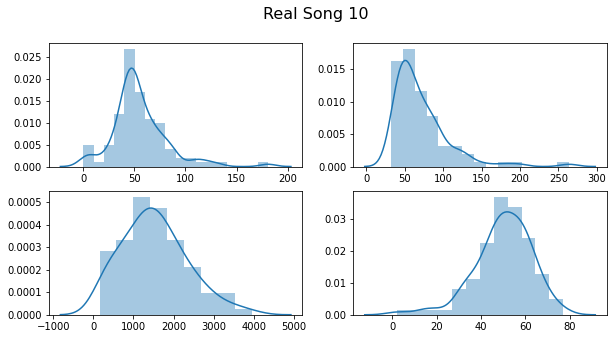

In [0]:
fig, axs = plt.subplots(2, 2, figsize=(10,5))
fig.suptitle('Real Song 10 ', fontsize=16)
sns.distplot(batch_data[10,:,0], ax=axs[0, 0])
sns.distplot(batch_data[10,:,1], ax=axs[0, 1])
sns.distplot(batch_data[10,:,2], ax=axs[1, 0])
sns.distplot(batch_data[10,:,3], ax=axs[1, 1])

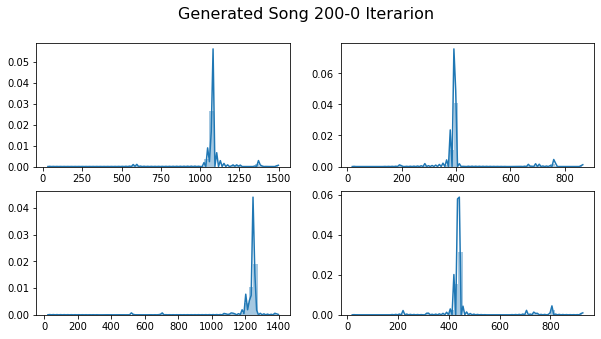

In [0]:
gen_song_complex_generator_200_deep = crnngan_vanilla_complex_generator_deep.generated_songs[200][0].cpu().numpy()
fig, axs = plt.subplots(2, 2, figsize=(10,5))
fig.suptitle('Generated Song 200-0 Iterarion', fontsize=16)
sns.distplot(gen_song_complex_generator_200_deep[:,0], ax=axs[0, 0])
sns.distplot(gen_song_complex_generator_200_deep[:,1], ax=axs[0, 1])
sns.distplot(gen_song_complex_generator_200_deep[:,2], ax=axs[1, 0])
sns.distplot(gen_song_complex_generator_200_deep[:,3], ax=axs[1, 1])

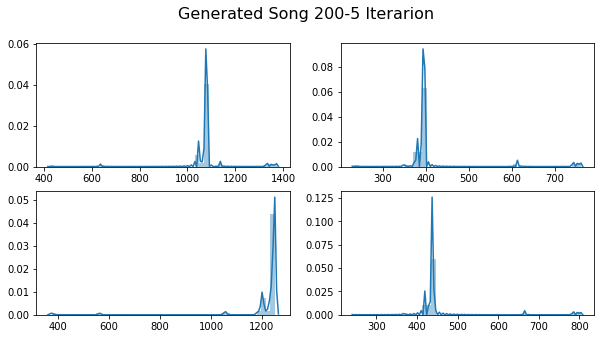

In [0]:
gen_song_complex_generator_200_5_deep = crnngan_vanilla_complex_generator_deep.generated_songs[200][5].cpu().numpy()
fig, axs = plt.subplots(2, 2, figsize=(10,5))
fig.suptitle('Generated Song 200-5 Iterarion', fontsize=16)
sns.distplot(gen_song_complex_generator_200_5_deep[:,0], ax=axs[0, 0])
sns.distplot(gen_song_complex_generator_200_5_deep[:,1], ax=axs[0, 1])
sns.distplot(gen_song_complex_generator_200_5_deep[:,2], ax=axs[1, 0])
sns.distplot(gen_song_complex_generator_200_5_deep[:,3], ax=axs[1, 1])

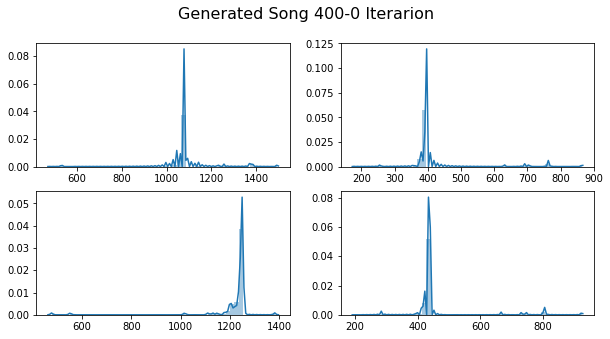

In [0]:
gen_song_complex_generator_400_deep = crnngan_vanilla_complex_generator_deep.generated_songs[400][0].cpu().numpy()
fig, axs = plt.subplots(2, 2, figsize=(10,5))
fig.suptitle('Generated Song 400-0 Iterarion', fontsize=16)
sns.distplot(gen_song_complex_generator_400_deep[:,0], ax=axs[0, 0])
sns.distplot(gen_song_complex_generator_400_deep[:,1], ax=axs[0, 1])
sns.distplot(gen_song_complex_generator_400_deep[:,2], ax=axs[1, 0])
sns.distplot(gen_song_complex_generator_400_deep[:,3], ax=axs[1, 1])

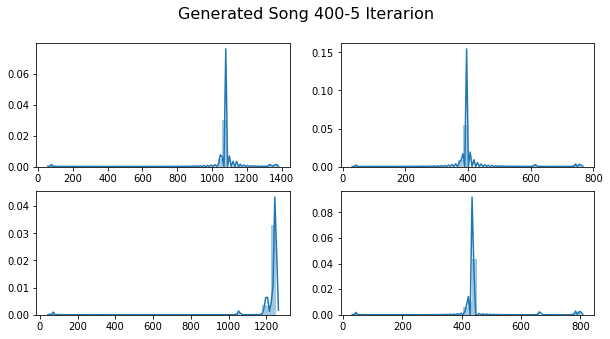

In [0]:
gen_song_complex_generator_400_5_deep = crnngan_vanilla_complex_generator_deep.generated_songs[400][5].cpu().numpy()
fig, axs = plt.subplots(2, 2, figsize=(10,5))
fig.suptitle('Generated Song 400-5 Iterarion', fontsize=16)
sns.distplot(gen_song_complex_generator_400_5_deep[:,0], ax=axs[0, 0])
sns.distplot(gen_song_complex_generator_400_5_deep[:,1], ax=axs[0, 1])
sns.distplot(gen_song_complex_generator_400_5_deep[:,2], ax=axs[1, 0])
sns.distplot(gen_song_complex_generator_400_5_deep[:,3], ax=axs[1, 1])

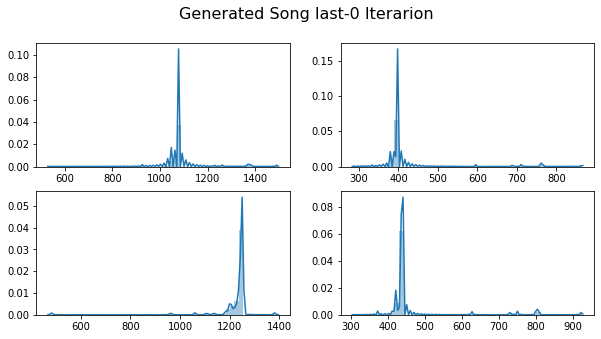

In [0]:
gen_song_complex_generator_last_deep = crnngan_vanilla_complex_generator_deep.generated_songs[-1][0].cpu().numpy()
fig, axs = plt.subplots(2, 2, figsize=(10,5))
fig.suptitle('Generated Song last-0 Iterarion', fontsize=16)
sns.distplot(gen_song_complex_generator_last_deep[:,0], ax=axs[0, 0])
sns.distplot(gen_song_complex_generator_last_deep[:,1], ax=axs[0, 1])
sns.distplot(gen_song_complex_generator_last_deep[:,2], ax=axs[1, 0])
sns.distplot(gen_song_complex_generator_last_deep[:,3], ax=axs[1, 1])

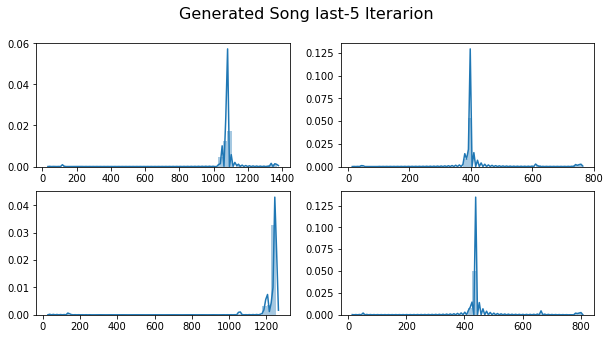

In [0]:
gen_song_complex_generator_last_5_deep = crnngan_vanilla_complex_generator_deep.generated_songs[-1][5].cpu().numpy()
fig, axs = plt.subplots(2, 2, figsize=(10,5))
fig.suptitle('Generated Song last-5 Iterarion', fontsize=16)
sns.distplot(gen_song_complex_generator_last_5_deep[:,0], ax=axs[0, 0])
sns.distplot(gen_song_complex_generator_last_5_deep[:,1], ax=axs[0, 1])
sns.distplot(gen_song_complex_generator_last_5_deep[:,2], ax=axs[1, 0])
sns.distplot(gen_song_complex_generator_last_5_deep[:,3], ax=axs[1, 1])

Does not look good... We'll try with a more complex discriminator while keeping the 'original' generator.

In [0]:
# Data loader
batch_length = 100
sequence_length = 100
# Generator parameters
in_channels_g = 20
out_channels_g = 4
hidden_dim_g = 350
n_layers_g = 2
# Discriminator parameters
in_channels_d = 4
out_channels_d = 2
hidden_dim_d = 350
n_layers_d = 2
# General
epochs = 50
curriculum_learning = False
complexDiscriminator = True

crnngan_vanilla_complex_discriminator = crnngan.CRNNGAN(batch_length, sequence_length,
                 in_channels_g, out_channels_g, hidden_dim_g, n_layers_g,
                 in_channels_d, out_channels_d, hidden_dim_d, n_layers_d,
                 curriculum_learning = curriculum_learning, epochs=epochs,
                 complexDiscriminator=complexDiscriminator)

cuda
Complex Discriminator


In [0]:
crnngan_vanilla_complex_discriminator.trainloop(musicDataLoader)

Start training for 50 epochs
[0/50][0]	Loss_D: 9.1831	Loss_G: 14.8976	D(x): -4.5694	D(G(z)): -4.6050 / 0.0000
 Time since epoch started: 0.15
There are a total of 0 fake songs saved already
[0/50][10]	Loss_D: 5.3442	Loss_G: 15.4402	D(x): -3.6337	D(G(z)): -0.1918 / -0.2071
 Time since epoch started: 1.51
There are a total of 5 fake songs saved already
[0/50][20]	Loss_D: 1.3529	Loss_G: 20.4595	D(x): -0.2704	D(G(z)): -0.0215 / -0.0228
 Time since epoch started: 2.86
There are a total of 10 fake songs saved already
Epoch time: 3.53
[1/50][30]	Loss_D: 1.8660	Loss_G: 12.8944	D(x): -0.0052	D(G(z)): -0.0032 / -0.0404
 Time since epoch started: 0.68
There are a total of 15 fake songs saved already
[1/50][40]	Loss_D: 1.9549	Loss_G: 14.4184	D(x): -0.5298	D(G(z)): -0.0149 / -0.0084
 Time since epoch started: 2.04
There are a total of 20 fake songs saved already
[1/50][50]	Loss_D: 11.1799	Loss_G: 17.1507	D(x): -0.7950	D(G(z)): -0.0039 / -0.0775
 Time since epoch started: 3.39
There are a total of 2

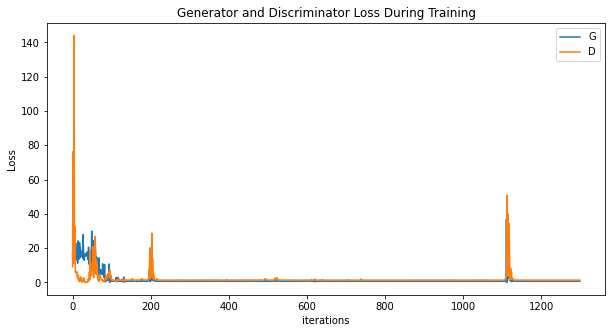

In [0]:
crnngan_vanilla_complex_discriminator.plot_losses()

In [0]:
seq_length = 100
batch_length = 100
musicDataLoader.rewind('train')
_, batch_data = musicDataLoader.get_batch(batchsize=batch_length, songlength=seq_length)

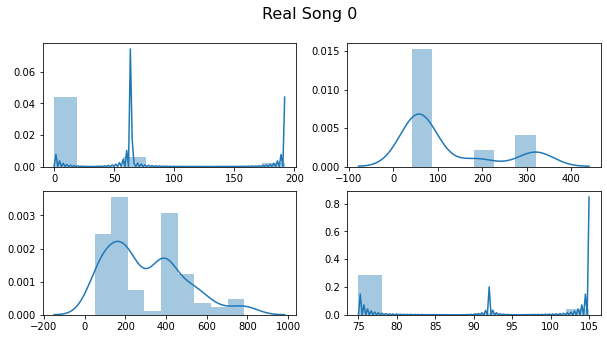

In [0]:
fig, axs = plt.subplots(2, 2, figsize=(10,5))
fig.suptitle('Real Song 0 ', fontsize=16)
sns.distplot(batch_data[0,:,0], ax=axs[0, 0])
sns.distplot(batch_data[0,:,1], ax=axs[0, 1])
sns.distplot(batch_data[0,:,2], ax=axs[1, 0])
sns.distplot(batch_data[0,:,3], ax=axs[1, 1])

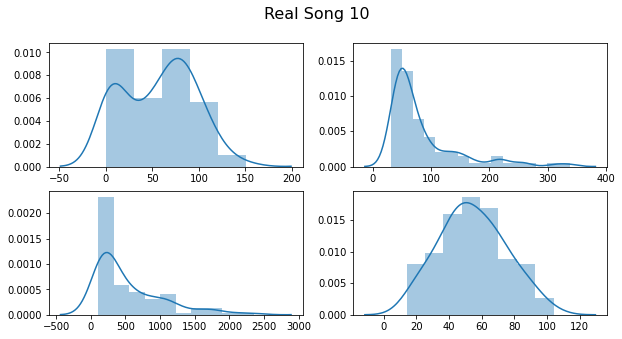

In [0]:
fig, axs = plt.subplots(2, 2, figsize=(10,5))
fig.suptitle('Real Song 10 ', fontsize=16)
sns.distplot(batch_data[10,:,0], ax=axs[0, 0])
sns.distplot(batch_data[10,:,1], ax=axs[0, 1])
sns.distplot(batch_data[10,:,2], ax=axs[1, 0])
sns.distplot(batch_data[10,:,3], ax=axs[1, 1])

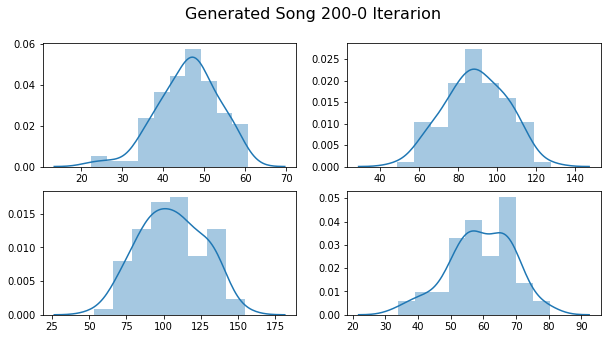

In [0]:
gen_song_complex_discriminator_200 = crnngan_vanilla_complex_discriminator.generated_songs[200][0].cpu().numpy()
fig, axs = plt.subplots(2, 2, figsize=(10,5))
fig.suptitle('Generated Song 200-0 Iterarion', fontsize=16)
sns.distplot(gen_song_complex_discriminator_200[:,0], ax=axs[0, 0])
sns.distplot(gen_song_complex_discriminator_200[:,1], ax=axs[0, 1])
sns.distplot(gen_song_complex_discriminator_200[:,2], ax=axs[1, 0])
sns.distplot(gen_song_complex_discriminator_200[:,3], ax=axs[1, 1])

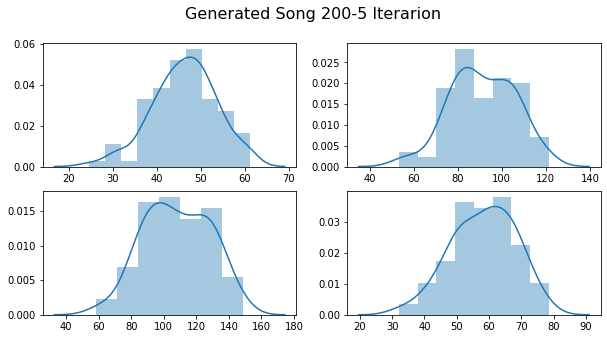

In [0]:
gen_song_complex_discriminator_200_5 = crnngan_vanilla_complex_discriminator.generated_songs[200][5].cpu().numpy()
fig, axs = plt.subplots(2, 2, figsize=(10,5))
fig.suptitle('Generated Song 200-5 Iterarion', fontsize=16)
sns.distplot(gen_song_complex_discriminator_200_5[:,0], ax=axs[0, 0])
sns.distplot(gen_song_complex_discriminator_200_5[:,1], ax=axs[0, 1])
sns.distplot(gen_song_complex_discriminator_200_5[:,2], ax=axs[1, 0])
sns.distplot(gen_song_complex_discriminator_200_5[:,3], ax=axs[1, 1])

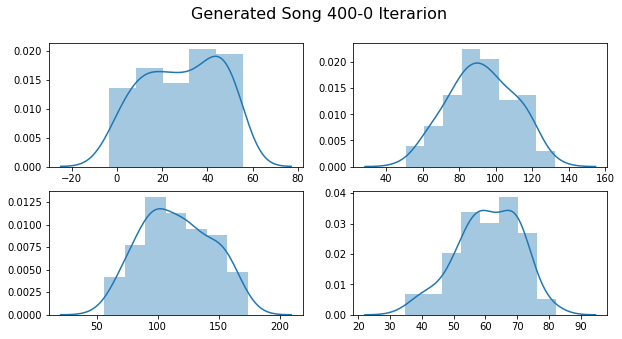

In [0]:
gen_song_complex_discriminator_400 = crnngan_vanilla_complex_discriminator.generated_songs[400][0].cpu().numpy()
fig, axs = plt.subplots(2, 2, figsize=(10,5))
fig.suptitle('Generated Song 400-0 Iterarion', fontsize=16)
sns.distplot(gen_song_complex_discriminator_400[:,0], ax=axs[0, 0])
sns.distplot(gen_song_complex_discriminator_400[:,1], ax=axs[0, 1])
sns.distplot(gen_song_complex_discriminator_400[:,2], ax=axs[1, 0])
sns.distplot(gen_song_complex_discriminator_400[:,3], ax=axs[1, 1])

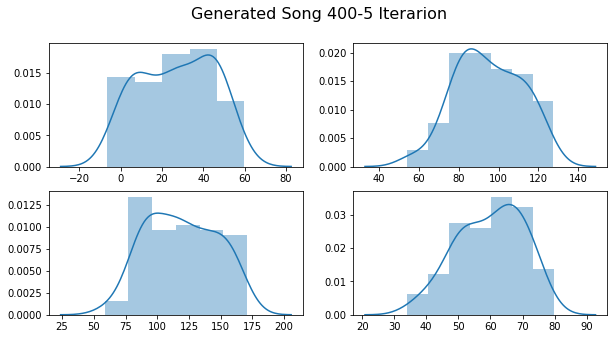

In [0]:
gen_song_complex_discriminator_400_5 = crnngan_vanilla_complex_discriminator.generated_songs[400][5].cpu().numpy()
fig, axs = plt.subplots(2, 2, figsize=(10,5))
fig.suptitle('Generated Song 400-5 Iterarion', fontsize=16)
sns.distplot(gen_song_complex_discriminator_400_5[:,0], ax=axs[0, 0])
sns.distplot(gen_song_complex_discriminator_400_5[:,1], ax=axs[0, 1])
sns.distplot(gen_song_complex_discriminator_400_5[:,2], ax=axs[1, 0])
sns.distplot(gen_song_complex_discriminator_400_5[:,3], ax=axs[1, 1])

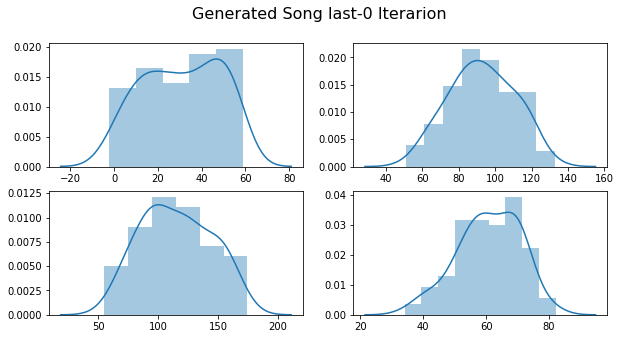

In [0]:
gen_song_complex_discriminator_last = crnngan_vanilla_complex_discriminator.generated_songs[-1][0].cpu().numpy()
fig, axs = plt.subplots(2, 2, figsize=(10,5))
fig.suptitle('Generated Song last-0 Iterarion', fontsize=16)
sns.distplot(gen_song_complex_discriminator_last[:,0], ax=axs[0, 0])
sns.distplot(gen_song_complex_discriminator_last[:,1], ax=axs[0, 1])
sns.distplot(gen_song_complex_discriminator_last[:,2], ax=axs[1, 0])
sns.distplot(gen_song_complex_discriminator_last[:,3], ax=axs[1, 1])

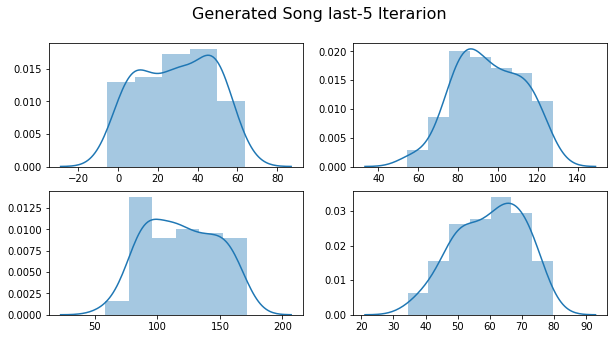

In [0]:
gen_song_complex_discriminator_last_5 = crnngan_vanilla_complex_discriminator.generated_songs[-1][5].cpu().numpy()
fig, axs = plt.subplots(2, 2, figsize=(10,5))
fig.suptitle('Generated Song last-5 Iterarion', fontsize=16)
sns.distplot(gen_song_complex_discriminator_last_5[:,0], ax=axs[0, 0])
sns.distplot(gen_song_complex_discriminator_last_5[:,1], ax=axs[0, 1])
sns.distplot(gen_song_complex_discriminator_last_5[:,2], ax=axs[1, 0])
sns.distplot(gen_song_complex_discriminator_last_5[:,3], ax=axs[1, 1])

These distributions don't look bad so we'll save the generated songs so we can listen them and see if they are any good.

In [0]:
save_path = './drive/My Drive/TFM/complex_discriminator_songs'
musicDataLoader.save_data(save_path+'/gen_song_complex_discriminator_200_0.midi', gen_song_complex_discriminator_200)
musicDataLoader.save_data(save_path+'/gen_song_complex_discriminator_200_5.midi', gen_song_complex_discriminator_200_5)
musicDataLoader.save_data(save_path+'/gen_song_complex_discriminator_400_0.midi', gen_song_complex_discriminator_400)
musicDataLoader.save_data(save_path+'/gen_song_complex_discriminator_400_5.midi', gen_song_complex_discriminator_400_5)
musicDataLoader.save_data(save_path+'/gen_song_complex_discriminator_last_0.midi', gen_song_complex_discriminator_last)
musicDataLoader.save_data(save_path+'/gen_song_complex_discriminator_last_5.midi', gen_song_complex_discriminator_last_5)

midi.Pattern(format=1, resolution=384, tracks=\
[midi.Track(\
  [midi.SetTempoEvent(tick=0, data=[20, 88, 85]),
   midi.NoteOnEvent(tick=18, channel=0, data=[46, 61]),
   midi.NoteOnEvent(tick=52, channel=0, data=[41, 51]),
   midi.NoteOffEvent(tick=39, channel=0, data=[46, 0]),
   midi.NoteOnEvent(tick=17, channel=0, data=[41, 65]),
   midi.NoteOnEvent(tick=9, channel=0, data=[49, 55]),
   midi.NoteOffEvent(tick=13, channel=0, data=[41, 0]),
   midi.NoteOnEvent(tick=40, channel=0, data=[41, 66]),
   midi.NoteOffEvent(tick=20, channel=0, data=[41, 0]),
   midi.NoteOnEvent(tick=27, channel=0, data=[39, 56]),
   midi.NoteOnEvent(tick=8, channel=0, data=[47, 57]),
   midi.NoteOnEvent(tick=0, channel=0, data=[52, 73]),
   midi.NoteOffEvent(tick=1, channel=0, data=[49, 0]),
   midi.NoteOnEvent(tick=1, channel=0, data=[49, 73]),
   midi.NoteOffEvent(tick=26, channel=0, data=[41, 0]),
   midi.NoteOnEvent(tick=33, channel=0, data=[41, 70]),
   midi.NoteOffEvent(tick=4, channel=0, data=[39, 0])

This case is not similar to the previous ones as more training doesn't seem to improve the listening quality of the generated songs. This happens both for the '_0' songs and for the '_5' songs. 

Maybe they are better but not thought to be interpreted by only one instrument. Either way, we'll try increasing the complexity a bit to see if anything improves.

In [0]:
# Data loader
batch_length = 100
sequence_length = 100
# Generator parameters
in_channels_g = 20
out_channels_g = 4
hidden_dim_g = 350
n_layers_g = 3
# Discriminator parameters
in_channels_d = 4
out_channels_d = 2
hidden_dim_d = 350
n_layers_d = 2
# General
epochs = 50
curriculum_learning = False
complexDiscriminator = True

crnngan_vanilla_complex_discriminator_balanced = crnngan.CRNNGAN(batch_length, sequence_length,
                 in_channels_g, out_channels_g, hidden_dim_g, n_layers_g,
                 in_channels_d, out_channels_d, hidden_dim_d, n_layers_d,
                 curriculum_learning = curriculum_learning, epochs=epochs,
                 complexDiscriminator=complexDiscriminator)

cuda
Complex Discriminator


In [0]:
crnngan_vanilla_complex_discriminator_balanced.trainloop(musicDataLoader)

Start training for 50 epochs
[0/50][0]	Loss_D: 9.2169	Loss_G: 1.8181	D(x): -4.5834	D(G(z)): -4.6033 / -0.0388
 Time since epoch started: 0.17
There are a total of 0 fake songs saved already
[0/50][10]	Loss_D: 2.7779	Loss_G: 9.6099	D(x): -0.7534	D(G(z)): -0.1817 / -0.0356
 Time since epoch started: 1.68
There are a total of 5 fake songs saved already
[0/50][20]	Loss_D: 2.7886	Loss_G: 12.5001	D(x): -0.0374	D(G(z)): -0.0199 / -0.1032
 Time since epoch started: 3.20
There are a total of 10 fake songs saved already
Epoch time: 3.97
[1/50][30]	Loss_D: 2.1230	Loss_G: 1.3018	D(x): -0.2505	D(G(z)): -0.0404 / -0.2462
 Time since epoch started: 0.76
There are a total of 15 fake songs saved already
[1/50][40]	Loss_D: 2.5394	Loss_G: 1.4128	D(x): -0.1372	D(G(z)): -0.2464 / -0.5495
 Time since epoch started: 2.28
There are a total of 20 fake songs saved already
[1/50][50]	Loss_D: 0.7723	Loss_G: 1.5271	D(x): -0.5356	D(G(z)): -0.0625 / -0.2723
 Time since epoch started: 3.79
There are a total of 25 fak

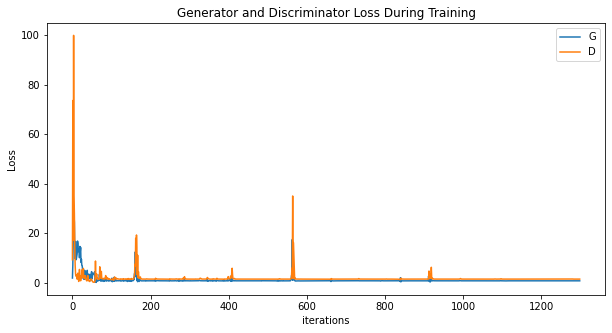

In [0]:
crnngan_vanilla_complex_discriminator_balanced.plot_losses()

In [0]:
seq_length = 100
batch_length = 100
musicDataLoader.rewind('train')
_, batch_data = musicDataLoader.get_batch(batchsize=batch_length, songlength=seq_length)

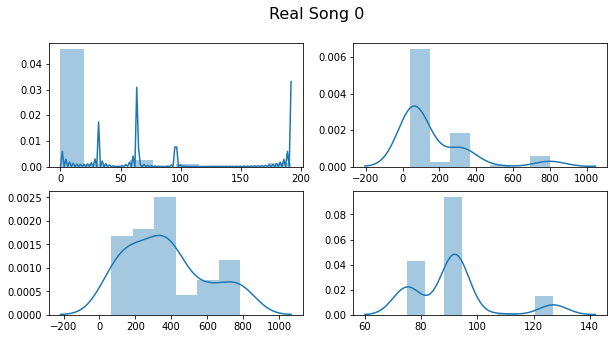

In [0]:
fig, axs = plt.subplots(2, 2, figsize=(10,5))
fig.suptitle('Real Song 0 ', fontsize=16)
sns.distplot(batch_data[0,:,0], ax=axs[0, 0])
sns.distplot(batch_data[0,:,1], ax=axs[0, 1])
sns.distplot(batch_data[0,:,2], ax=axs[1, 0])
sns.distplot(batch_data[0,:,3], ax=axs[1, 1])

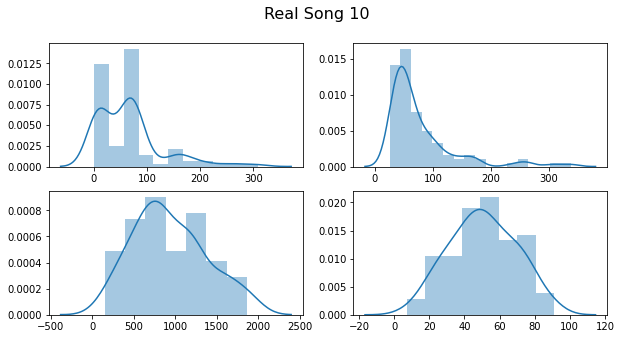

In [0]:
fig, axs = plt.subplots(2, 2, figsize=(10,5))
fig.suptitle('Real Song 10 ', fontsize=16)
sns.distplot(batch_data[10,:,0], ax=axs[0, 0])
sns.distplot(batch_data[10,:,1], ax=axs[0, 1])
sns.distplot(batch_data[10,:,2], ax=axs[1, 0])
sns.distplot(batch_data[10,:,3], ax=axs[1, 1])

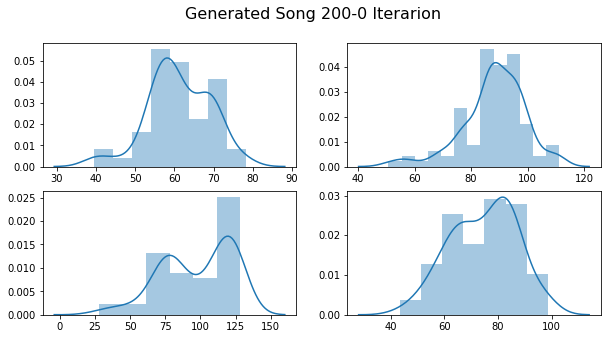

In [0]:
gen_song_complex_discriminator_200_balanced = crnngan_vanilla_complex_discriminator_balanced.generated_songs[200][0].cpu().numpy()
fig, axs = plt.subplots(2, 2, figsize=(10,5))
fig.suptitle('Generated Song 200-0 Iterarion', fontsize=16)
sns.distplot(gen_song_complex_discriminator_200_balanced[:,0], ax=axs[0, 0])
sns.distplot(gen_song_complex_discriminator_200_balanced[:,1], ax=axs[0, 1])
sns.distplot(gen_song_complex_discriminator_200_balanced[:,2], ax=axs[1, 0])
sns.distplot(gen_song_complex_discriminator_200_balanced[:,3], ax=axs[1, 1])

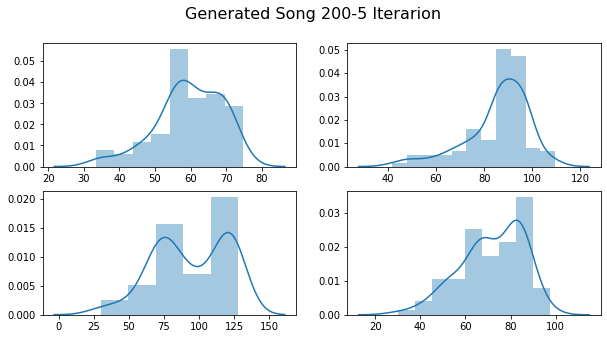

In [0]:
gen_song_complex_discriminator_200_5_balanced = crnngan_vanilla_complex_discriminator_balanced.generated_songs[200][5].cpu().numpy()
fig, axs = plt.subplots(2, 2, figsize=(10,5))
fig.suptitle('Generated Song 200-5 Iterarion', fontsize=16)
sns.distplot(gen_song_complex_discriminator_200_5_balanced[:,0], ax=axs[0, 0])
sns.distplot(gen_song_complex_discriminator_200_5_balanced[:,1], ax=axs[0, 1])
sns.distplot(gen_song_complex_discriminator_200_5_balanced[:,2], ax=axs[1, 0])
sns.distplot(gen_song_complex_discriminator_200_5_balanced[:,3], ax=axs[1, 1])

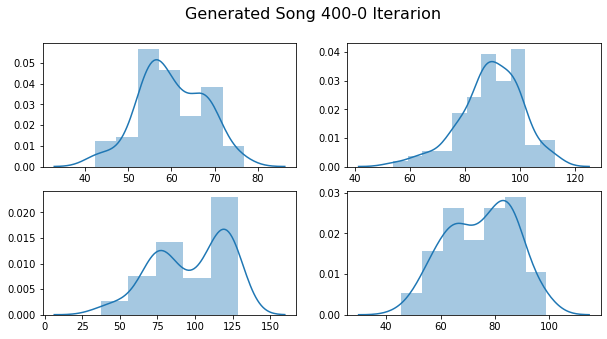

In [0]:
gen_song_complex_discriminator_400_balanced = crnngan_vanilla_complex_discriminator_balanced.generated_songs[400][0].cpu().numpy()
fig, axs = plt.subplots(2, 2, figsize=(10,5))
fig.suptitle('Generated Song 400-0 Iterarion', fontsize=16)
sns.distplot(gen_song_complex_discriminator_400_balanced[:,0], ax=axs[0, 0])
sns.distplot(gen_song_complex_discriminator_400_balanced[:,1], ax=axs[0, 1])
sns.distplot(gen_song_complex_discriminator_400_balanced[:,2], ax=axs[1, 0])
sns.distplot(gen_song_complex_discriminator_400_balanced[:,3], ax=axs[1, 1])

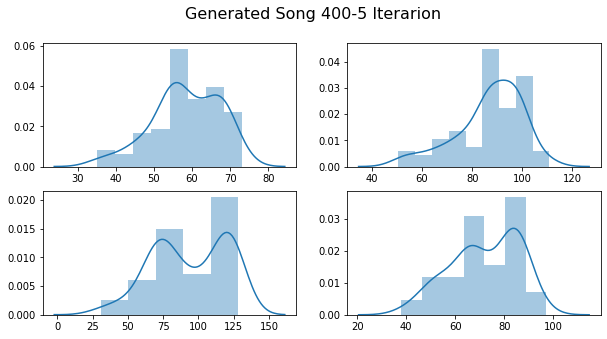

In [0]:
gen_song_complex_discriminator_400_5_balanced = crnngan_vanilla_complex_discriminator_balanced.generated_songs[400][5].cpu().numpy()
fig, axs = plt.subplots(2, 2, figsize=(10,5))
fig.suptitle('Generated Song 400-5 Iterarion', fontsize=16)
sns.distplot(gen_song_complex_discriminator_400_5_balanced[:,0], ax=axs[0, 0])
sns.distplot(gen_song_complex_discriminator_400_5_balanced[:,1], ax=axs[0, 1])
sns.distplot(gen_song_complex_discriminator_400_5_balanced[:,2], ax=axs[1, 0])
sns.distplot(gen_song_complex_discriminator_400_5_balanced[:,3], ax=axs[1, 1])

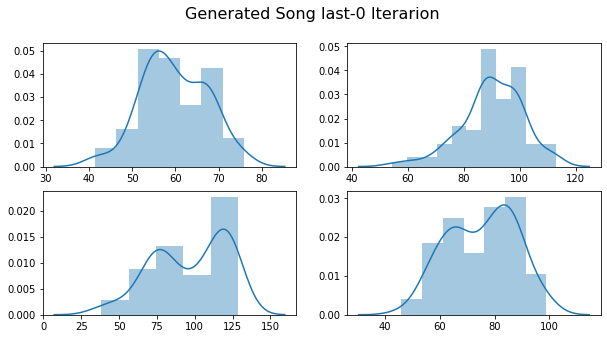

In [0]:
gen_song_complex_discriminator_last_balanced = crnngan_vanilla_complex_discriminator_balanced.generated_songs[-1][0].cpu().numpy()
fig, axs = plt.subplots(2, 2, figsize=(10,5))
fig.suptitle('Generated Song last-0 Iterarion', fontsize=16)
sns.distplot(gen_song_complex_discriminator_last_balanced[:,0], ax=axs[0, 0])
sns.distplot(gen_song_complex_discriminator_last_balanced[:,1], ax=axs[0, 1])
sns.distplot(gen_song_complex_discriminator_last_balanced[:,2], ax=axs[1, 0])
sns.distplot(gen_song_complex_discriminator_last_balanced[:,3], ax=axs[1, 1])

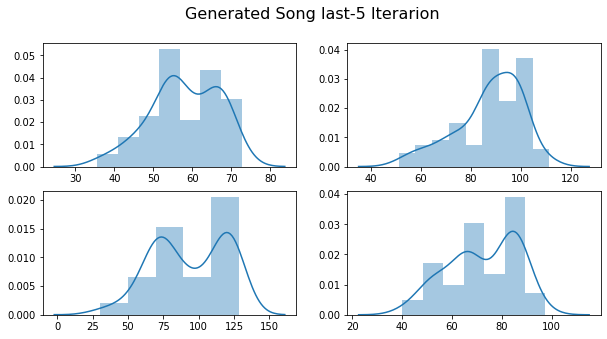

In [0]:
gen_song_complex_discriminator_last_5_balanced = crnngan_vanilla_complex_discriminator_balanced.generated_songs[-1][5].cpu().numpy()
fig, axs = plt.subplots(2, 2, figsize=(10,5))
fig.suptitle('Generated Song last-5 Iterarion', fontsize=16)
sns.distplot(gen_song_complex_discriminator_last_5_balanced[:,0], ax=axs[0, 0])
sns.distplot(gen_song_complex_discriminator_last_5_balanced[:,1], ax=axs[0, 1])
sns.distplot(gen_song_complex_discriminator_last_5_balanced[:,2], ax=axs[1, 0])
sns.distplot(gen_song_complex_discriminator_last_5_balanced[:,3], ax=axs[1, 1])

The convergence graph and the distribution graphs look good se we'll save the songs so that we can listen to them.

In [0]:
save_path = './drive/My Drive/TFM/complex_discriminator_balanced_songs'
musicDataLoader.save_data(save_path+'/gen_song_complex_discriminator_balanced_200_0.midi', gen_song_complex_discriminator_200_balanced)
musicDataLoader.save_data(save_path+'/gen_song_complex_discriminator_balanced_200_5.midi', gen_song_complex_discriminator_200_5_balanced)
musicDataLoader.save_data(save_path+'/gen_song_complex_discriminator_balanced_400_0.midi', gen_song_complex_discriminator_400_balanced)
musicDataLoader.save_data(save_path+'/gen_song_complex_discriminator_balanced_400_5.midi', gen_song_complex_discriminator_400_5_balanced)
musicDataLoader.save_data(save_path+'/gen_song_complex_discriminator_balanced_last_0.midi', gen_song_complex_discriminator_last_balanced)
musicDataLoader.save_data(save_path+'/gen_song_complex_discriminator_balanced_last_5.midi', gen_song_complex_discriminator_last_5_balanced)

midi.Pattern(format=1, resolution=384, tracks=\
[midi.Track(\
  [midi.SetTempoEvent(tick=0, data=[20, 88, 85]),
   midi.NoteOnEvent(tick=47, channel=0, data=[42, 53]),
   midi.NoteOnEvent(tick=68, channel=0, data=[37, 87]),
   midi.NoteOffEvent(tick=2, channel=0, data=[42, 0]),
   midi.NoteOnEvent(tick=61, channel=0, data=[41, 85]),
   midi.NoteOffEvent(tick=36, channel=0, data=[37, 0]),
   midi.NoteOnEvent(tick=20, channel=0, data=[32, 71]),
   midi.NoteOffEvent(tick=41, channel=0, data=[41, 0]),
   midi.NoteOnEvent(tick=30, channel=0, data=[46, 90]),
   midi.NoteOffEvent(tick=10, channel=0, data=[32, 0]),
   midi.NoteOnEvent(tick=39, channel=0, data=[38, 61]),
   midi.NoteOffEvent(tick=56, channel=0, data=[46, 0]),
   midi.NoteOnEvent(tick=13, channel=0, data=[47, 84]),
   midi.NoteOffEvent(tick=3, channel=0, data=[38, 0]),
   midi.NoteOnEvent(tick=64, channel=0, data=[37, 86]),
   midi.NoteOffEvent(tick=35, channel=0, data=[47, 0]),
   midi.NoteOnEvent(tick=19, channel=0, data=[45, 

These songs seem to follow more patterns than those generated previously, which means this structure is good. We'll not try making it a bit deeper.

With respect to the difference between samples generated with a more or a less trained version, we see some differences however, they are bearely noticeable by listening to them...

In [0]:
# Data loader
batch_length = 100
sequence_length = 100
# Generator parameters
in_channels_g = 20
out_channels_g = 4
hidden_dim_g = 350
n_layers_g = 3
# Discriminator parameters
in_channels_d = 4
out_channels_d = 2
hidden_dim_d = 350
n_layers_d = 3
# General
epochs = 50
curriculum_learning = False
complexDiscriminator = True

crnngan_vanilla_complex_discriminator_deep = crnngan.CRNNGAN(batch_length, sequence_length,
                 in_channels_g, out_channels_g, hidden_dim_g, n_layers_g,
                 in_channels_d, out_channels_d, hidden_dim_d, n_layers_d,
                 curriculum_learning = curriculum_learning, epochs=epochs,
                 complexDiscriminator=complexDiscriminator)

cuda
Complex Discriminator


In [0]:
crnngan_vanilla_complex_discriminator_deep.trainloop(musicDataLoader)

Start training for 50 epochs
[0/50][0]	Loss_D: 9.2131	Loss_G: 19.6429	D(x): -4.5976	D(G(z)): -4.6051 / 0.0000
 Time since epoch started: 0.20
There are a total of 0 fake songs saved already
[0/50][10]	Loss_D: 14.4724	Loss_G: 15.4460	D(x): -0.1678	D(G(z)): -0.2037 / -2.1864
 Time since epoch started: 2.03
There are a total of 5 fake songs saved already
[0/50][20]	Loss_D: 1.5518	Loss_G: 0.8504	D(x): -0.4001	D(G(z)): -0.4328 / -0.3020
 Time since epoch started: 3.87
There are a total of 10 fake songs saved already
Epoch time: 4.78
[1/50][30]	Loss_D: 3.2131	Loss_G: 1.0208	D(x): -0.0332	D(G(z)): -0.0317 / -0.4752
 Time since epoch started: 0.92
There are a total of 15 fake songs saved already
[1/50][40]	Loss_D: 1.4798	Loss_G: 0.8410	D(x): -0.3682	D(G(z)): -0.4309 / -0.3524
 Time since epoch started: 2.75
There are a total of 20 fake songs saved already
[1/50][50]	Loss_D: 3.0641	Loss_G: 4.2117	D(x): -0.0576	D(G(z)): -0.0646 / -0.0001
 Time since epoch started: 4.59
There are a total of 25 fa

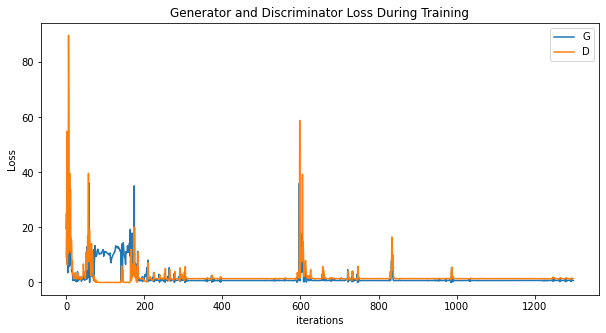

In [0]:
crnngan_vanilla_complex_discriminator_deep.plot_losses()

In [0]:
seq_length = 100
batch_length = 100
musicDataLoader.rewind('train')
_, batch_data = musicDataLoader.get_batch(batchsize=batch_length, songlength=seq_length)

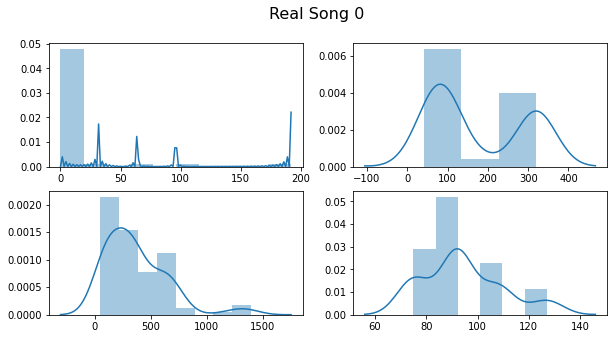

In [0]:
fig, axs = plt.subplots(2, 2, figsize=(10,5))
fig.suptitle('Real Song 0 ', fontsize=16)
sns.distplot(batch_data[0,:,0], ax=axs[0, 0])
sns.distplot(batch_data[0,:,1], ax=axs[0, 1])
sns.distplot(batch_data[0,:,2], ax=axs[1, 0])
sns.distplot(batch_data[0,:,3], ax=axs[1, 1])

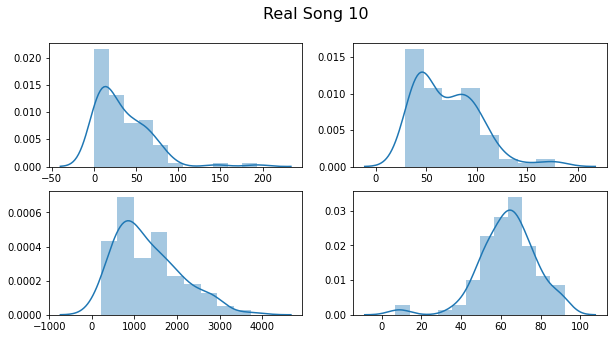

In [0]:
fig, axs = plt.subplots(2, 2, figsize=(10,5))
fig.suptitle('Real Song 10 ', fontsize=16)
sns.distplot(batch_data[10,:,0], ax=axs[0, 0])
sns.distplot(batch_data[10,:,1], ax=axs[0, 1])
sns.distplot(batch_data[10,:,2], ax=axs[1, 0])
sns.distplot(batch_data[10,:,3], ax=axs[1, 1])

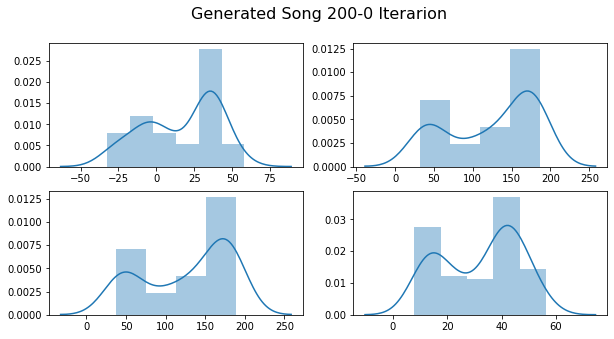

In [0]:
gen_song_complex_discriminator_200_deep = crnngan_vanilla_complex_discriminator_deep.generated_songs[200][0].cpu().numpy()
fig, axs = plt.subplots(2, 2, figsize=(10,5))
fig.suptitle('Generated Song 200-0 Iterarion', fontsize=16)
sns.distplot(gen_song_complex_discriminator_200_deep[:,0], ax=axs[0, 0])
sns.distplot(gen_song_complex_discriminator_200_deep[:,1], ax=axs[0, 1])
sns.distplot(gen_song_complex_discriminator_200_deep[:,2], ax=axs[1, 0])
sns.distplot(gen_song_complex_discriminator_200_deep[:,3], ax=axs[1, 1])

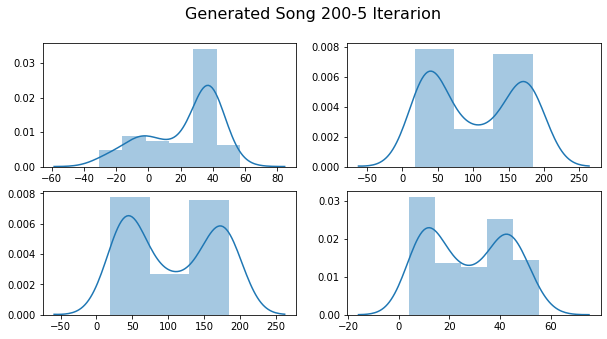

In [0]:
gen_song_complex_discriminator_200_5_deep = crnngan_vanilla_complex_discriminator_deep.generated_songs[200][5].cpu().numpy()
fig, axs = plt.subplots(2, 2, figsize=(10,5))
fig.suptitle('Generated Song 200-5 Iterarion', fontsize=16)
sns.distplot(gen_song_complex_discriminator_200_5_deep[:,0], ax=axs[0, 0])
sns.distplot(gen_song_complex_discriminator_200_5_deep[:,1], ax=axs[0, 1])
sns.distplot(gen_song_complex_discriminator_200_5_deep[:,2], ax=axs[1, 0])
sns.distplot(gen_song_complex_discriminator_200_5_deep[:,3], ax=axs[1, 1])

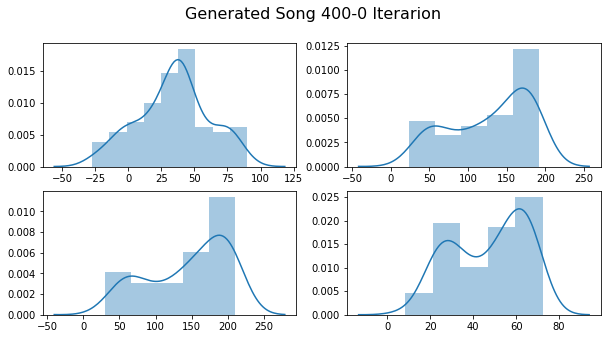

In [0]:
gen_song_complex_discriminator_400_deep = crnngan_vanilla_complex_discriminator_deep.generated_songs[400][0].cpu().numpy()
fig, axs = plt.subplots(2, 2, figsize=(10,5))
fig.suptitle('Generated Song 400-0 Iterarion', fontsize=16)
sns.distplot(gen_song_complex_discriminator_400_deep[:,0], ax=axs[0, 0])
sns.distplot(gen_song_complex_discriminator_400_deep[:,1], ax=axs[0, 1])
sns.distplot(gen_song_complex_discriminator_400_deep[:,2], ax=axs[1, 0])
sns.distplot(gen_song_complex_discriminator_400_deep[:,3], ax=axs[1, 1])

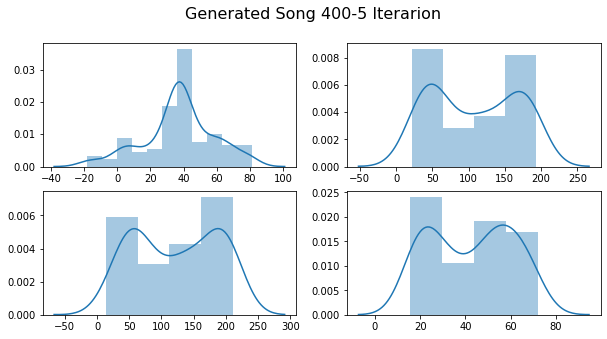

In [0]:
gen_song_complex_discriminator_400_5_deep = crnngan_vanilla_complex_discriminator_deep.generated_songs[400][5].cpu().numpy()
fig, axs = plt.subplots(2, 2, figsize=(10,5))
fig.suptitle('Generated Song 400-5 Iterarion', fontsize=16)
sns.distplot(gen_song_complex_discriminator_400_5_deep[:,0], ax=axs[0, 0])
sns.distplot(gen_song_complex_discriminator_400_5_deep[:,1], ax=axs[0, 1])
sns.distplot(gen_song_complex_discriminator_400_5_deep[:,2], ax=axs[1, 0])
sns.distplot(gen_song_complex_discriminator_400_5_deep[:,3], ax=axs[1, 1])

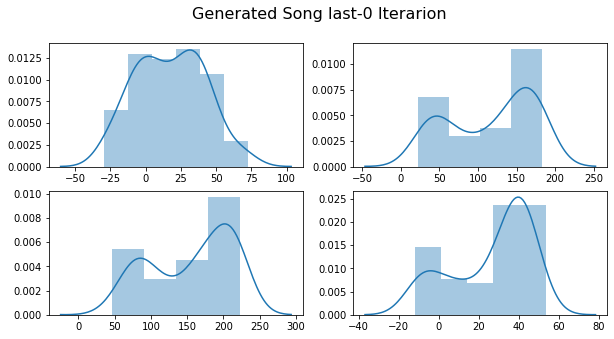

In [0]:
gen_song_complex_discriminator_last_deep = crnngan_vanilla_complex_discriminator_deep.generated_songs[-1][0].cpu().numpy()
fig, axs = plt.subplots(2, 2, figsize=(10,5))
fig.suptitle('Generated Song last-0 Iterarion', fontsize=16)
sns.distplot(gen_song_complex_discriminator_last_deep[:,0], ax=axs[0, 0])
sns.distplot(gen_song_complex_discriminator_last_deep[:,1], ax=axs[0, 1])
sns.distplot(gen_song_complex_discriminator_last_deep[:,2], ax=axs[1, 0])
sns.distplot(gen_song_complex_discriminator_last_deep[:,3], ax=axs[1, 1])

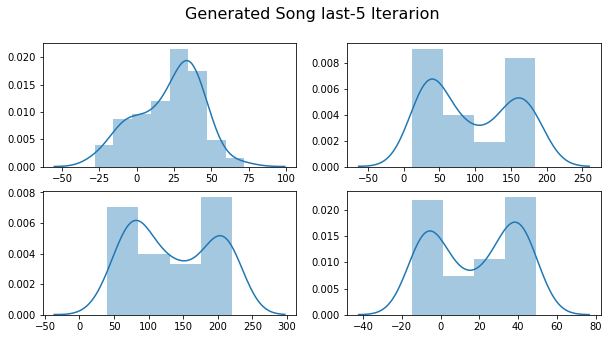

In [0]:
gen_song_complex_discriminator_last_5_deep = crnngan_vanilla_complex_discriminator_deep.generated_songs[-1][5].cpu().numpy()
fig, axs = plt.subplots(2, 2, figsize=(10,5))
fig.suptitle('Generated Song last-5 Iterarion', fontsize=16)
sns.distplot(gen_song_complex_discriminator_last_5_deep[:,0], ax=axs[0, 0])
sns.distplot(gen_song_complex_discriminator_last_5_deep[:,1], ax=axs[0, 1])
sns.distplot(gen_song_complex_discriminator_last_5_deep[:,2], ax=axs[1, 0])
sns.distplot(gen_song_complex_discriminator_last_5_deep[:,3], ax=axs[1, 1])

Both convergence and distributions look good, therefore, we'll save again the songs to take a listen.

In [0]:
save_path = './drive/My Drive/TFM/complex_discriminator_deep_songs'
musicDataLoader.save_data(save_path+'/gen_song_complex_discriminator_deep_200_0.midi', gen_song_complex_discriminator_200_deep)
musicDataLoader.save_data(save_path+'/gen_song_complex_discriminator_deep_200_5.midi', gen_song_complex_discriminator_200_5_deep)
musicDataLoader.save_data(save_path+'/gen_song_complex_discriminator_deep_400_0.midi', gen_song_complex_discriminator_400_deep)
musicDataLoader.save_data(save_path+'/gen_song_complex_discriminator_deep_400_5.midi', gen_song_complex_discriminator_400_5_deep)
musicDataLoader.save_data(save_path+'/gen_song_complex_discriminator_deep_last_0.midi', gen_song_complex_discriminator_last_deep)
musicDataLoader.save_data(save_path+'/gen_song_complex_discriminator_deep_last_5.midi', gen_song_complex_discriminator_last_5_deep)

midi.Pattern(format=1, resolution=384, tracks=\
[midi.Track(\
  [midi.SetTempoEvent(tick=0, data=[20, 88, 85]),
   midi.NoteOnEvent(tick=-10, channel=0, data=[56, 42]),
   midi.NoteOnEvent(tick=71, channel=0, data=[47, 5]),
   midi.NoteOnEvent(tick=28, channel=0, data=[48, 31]),
   midi.NoteOnEvent(tick=11, channel=0, data=[45, 31]),
   midi.NoteOnEvent(tick=32, channel=0, data=[57, 42]),
   midi.NoteOffEvent(tick=7, channel=0, data=[47, 0]),
   midi.NoteOffEvent(tick=35, channel=0, data=[56, 0]),
   midi.NoteOffEvent(tick=18, channel=0, data=[45, 0]),
   midi.NoteOnEvent(tick=5, channel=0, data=[51, 44]),
   midi.NoteOffEvent(tick=6, channel=0, data=[48, 0]),
   midi.NoteOnEvent(tick=5, channel=0, data=[50, 29]),
   midi.NoteOnEvent(tick=2, channel=0, data=[56, 39]),
   midi.NoteOnEvent(tick=24, channel=0, data=[54, 49]),
   midi.NoteOnEvent(tick=24, channel=0, data=[57, 42]),
   midi.NoteOffEvent(tick=49, channel=0, data=[50, 0]),
   midi.NoteOnEvent(tick=1, channel=0, data=[56, 42])

It sounds like if there were too many things going on at the same time... Either way and as we were expecting maybe these generated songs shouldn't be interpreted by only one instrument...

However, we've been able to obtain some good songs, also, the difference in case is quite noticeable, being the best generated song the one around 400, so we'll save more like that one.

In [0]:
save_path = './drive/My Drive/TFM/complex_discriminator_deep_songs/400'
gen_song_complex_discriminator_400_deep = crnngan_vanilla_complex_discriminator_deep.generated_songs[400][0].cpu().numpy()
musicDataLoader.save_data(save_path+'/gen_song_complex_discriminator_deep_400_0.midi', gen_song_complex_discriminator_400_deep)
gen_song_complex_discriminator_400_1_deep = crnngan_vanilla_complex_discriminator_deep.generated_songs[400][1].cpu().numpy()
musicDataLoader.save_data(save_path+'/gen_song_complex_discriminator_deep_400_1_0.midi', gen_song_complex_discriminator_400_1_deep)
gen_song_complex_discriminator_400_2_deep = crnngan_vanilla_complex_discriminator_deep.generated_songs[400][2].cpu().numpy()
musicDataLoader.save_data(save_path+'/gen_song_complex_discriminator_deep_400_2_0.midi', gen_song_complex_discriminator_400_2_deep)
gen_song_complex_discriminator_400_3_deep = crnngan_vanilla_complex_discriminator_deep.generated_songs[400][3].cpu().numpy()
musicDataLoader.save_data(save_path+'/gen_song_complex_discriminator_deep_400_3_0.midi', gen_song_complex_discriminator_400_3_deep)
gen_song_complex_discriminator_400_4_deep = crnngan_vanilla_complex_discriminator_deep.generated_songs[400][4].cpu().numpy()
musicDataLoader.save_data(save_path+'/gen_song_complex_discriminator_deep_400_4_0.midi', gen_song_complex_discriminator_400_4_deep)
gen_song_complex_discriminator_400_5_deep = crnngan_vanilla_complex_discriminator_deep.generated_songs[400][5].cpu().numpy()
musicDataLoader.save_data(save_path+'/gen_song_complex_discriminator_deep_400_5_0.midi', gen_song_complex_discriminator_400_5_deep)
gen_song_complex_discriminator_400_6_deep = crnngan_vanilla_complex_discriminator_deep.generated_songs[400][6].cpu().numpy()
musicDataLoader.save_data(save_path+'/gen_song_complex_discriminator_deep_400_6_0.midi', gen_song_complex_discriminator_400_6_deep)
gen_song_complex_discriminator_400_7_deep = crnngan_vanilla_complex_discriminator_deep.generated_songs[400][7].cpu().numpy()
musicDataLoader.save_data(save_path+'/gen_song_complex_discriminator_deep_400_7_0.midi', gen_song_complex_discriminator_400_7_deep)
gen_song_complex_discriminator_400_8_deep = crnngan_vanilla_complex_discriminator_deep.generated_songs[400][8].cpu().numpy()
musicDataLoader.save_data(save_path+'/gen_song_complex_discriminator_deep_400_8_0.midi', gen_song_complex_discriminator_400_8_deep)
gen_song_complex_discriminator_400_9_deep = crnngan_vanilla_complex_discriminator_deep.generated_songs[400][9].cpu().numpy()
musicDataLoader.save_data(save_path+'/gen_song_complex_discriminator_deep_400_9_0.midi', gen_song_complex_discriminator_400_9_deep)

midi.Pattern(format=1, resolution=384, tracks=\
[midi.Track(\
  [midi.SetTempoEvent(tick=0, data=[20, 88, 85]),
   midi.NoteOnEvent(tick=-11, channel=0, data=[54, 42]),
   midi.NoteOnEvent(tick=40, channel=0, data=[44, 27]),
   midi.NoteOnEvent(tick=36, channel=0, data=[36, 29]),
   midi.NoteOnEvent(tick=45, channel=0, data=[55, 68]),
   midi.NoteOffEvent(tick=7, channel=0, data=[44, 0]),
   midi.NoteOffEvent(tick=5, channel=0, data=[36, 0]),
   midi.NoteOnEvent(tick=18, channel=0, data=[55, 60]),
   midi.NoteOffEvent(tick=22, channel=0, data=[54, 0]),
   midi.NoteOnEvent(tick=30, channel=0, data=[38, 33]),
   midi.NoteOnEvent(tick=38, channel=0, data=[40, 27]),
   midi.NoteOnEvent(tick=1, channel=0, data=[55, 51]),
   midi.NoteOffEvent(tick=21, channel=0, data=[38, 0]),
   midi.NoteOffEvent(tick=35, channel=0, data=[55, 0]),
   midi.NoteOffEvent(tick=11, channel=0, data=[40, 0]),
   midi.NoteOnEvent(tick=8, channel=0, data=[50, 70]),
   midi.NoteOffEvent(tick=17, channel=0, data=[55, 

This makes more important the fact that early stopping is something that should be taken care of.

Let's try now with both generator and discriminator using a complex estructure.

In [0]:
# Data loader
batch_length = 100
sequence_length = 100
# Generator parameters
in_channels_g = 20
out_channels_g = 4
hidden_dim_g = 350
n_layers_g = 2
# Discriminator parameters
in_channels_d = 4
out_channels_d = 2
hidden_dim_d = 350
n_layers_d = 2
# General
epochs = 50
curriculum_learning = False
complexDiscriminator = True
complexGenerator = True

crnngan_vanilla_both_complex = crnngan.CRNNGAN(batch_length, sequence_length,
                 in_channels_g, out_channels_g, hidden_dim_g, n_layers_g,
                 in_channels_d, out_channels_d, hidden_dim_d, n_layers_d,
                 curriculum_learning = curriculum_learning, epochs=epochs,
                 complexDiscriminator=complexDiscriminator, complexGenerator=complexGenerator)

cuda
Complex Generator
Complex Discriminator


In [0]:
crnngan_vanilla_both_complex.trainloop(musicDataLoader)

Start training for 50 epochs
[0/50][0]	Loss_D: 9.2112	Loss_G: 5.3349	D(x): -4.5865	D(G(z)): -4.6048 / -0.0207
 Time since epoch started: 0.16
There are a total of 0 fake songs saved already
[0/50][10]	Loss_D: 42.8237	Loss_G: 38.7025	D(x): -2.2740	D(G(z)): -0.0905 / -0.2281
 Time since epoch started: 1.54
There are a total of 5 fake songs saved already
[0/50][20]	Loss_D: 0.0453	Loss_G: 42.7034	D(x): -0.0453	D(G(z)): -0.0000 / -0.0000
 Time since epoch started: 2.93
There are a total of 10 fake songs saved already
Epoch time: 3.62
[1/50][30]	Loss_D: 0.0001	Loss_G: 30.7087	D(x): -0.0000	D(G(z)): -0.0001 / -0.0000
 Time since epoch started: 0.69
There are a total of 15 fake songs saved already
[1/50][40]	Loss_D: 0.0000	Loss_G: 38.4155	D(x): -0.0000	D(G(z)): -0.0000 / -0.0000
 Time since epoch started: 2.08
There are a total of 20 fake songs saved already
[1/50][50]	Loss_D: 0.0000	Loss_G: 20.0475	D(x): -0.0000	D(G(z)): -0.0000 / -0.0000
 Time since epoch started: 3.45
There are a total of 2

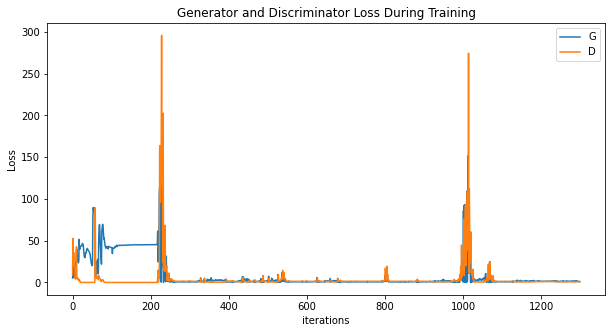

In [269]:
crnngan_vanilla_both_complex.plot_losses()

In [0]:
seq_length = 100
batch_length = 100
musicDataLoader.rewind('train')
_, batch_data = musicDataLoader.get_batch(batchsize=batch_length, songlength=seq_length)

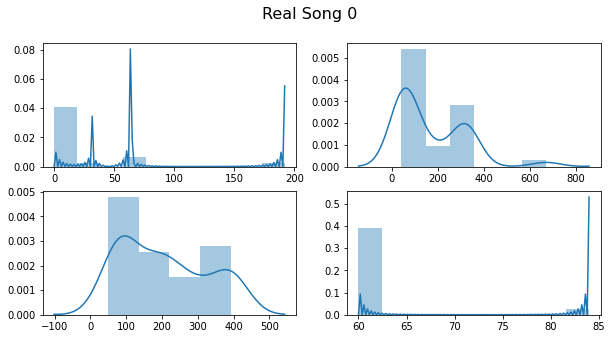

In [271]:
fig, axs = plt.subplots(2, 2, figsize=(10,5))
fig.suptitle('Real Song 0 ', fontsize=16)
sns.distplot(batch_data[0,:,0], ax=axs[0, 0])
sns.distplot(batch_data[0,:,1], ax=axs[0, 1])
sns.distplot(batch_data[0,:,2], ax=axs[1, 0])
sns.distplot(batch_data[0,:,3], ax=axs[1, 1])

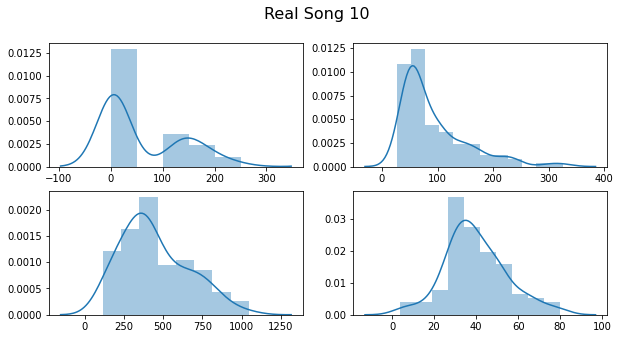

In [272]:
fig, axs = plt.subplots(2, 2, figsize=(10,5))
fig.suptitle('Real Song 10 ', fontsize=16)
sns.distplot(batch_data[10,:,0], ax=axs[0, 0])
sns.distplot(batch_data[10,:,1], ax=axs[0, 1])
sns.distplot(batch_data[10,:,2], ax=axs[1, 0])
sns.distplot(batch_data[10,:,3], ax=axs[1, 1])

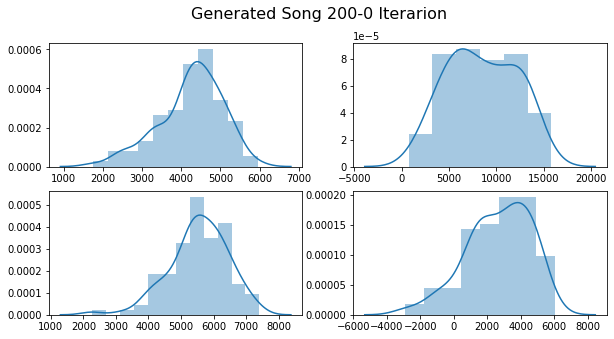

In [273]:
gen_song_both_complex_200_0 = crnngan_vanilla_both_complex.generated_songs[200][0].cpu().numpy()
fig, axs = plt.subplots(2, 2, figsize=(10,5))
fig.suptitle('Generated Song 200-0 Iterarion', fontsize=16)
sns.distplot(gen_song_both_complex_200_0[:,0], ax=axs[0, 0])
sns.distplot(gen_song_both_complex_200_0[:,1], ax=axs[0, 1])
sns.distplot(gen_song_both_complex_200_0[:,2], ax=axs[1, 0])
sns.distplot(gen_song_both_complex_200_0[:,3], ax=axs[1, 1])

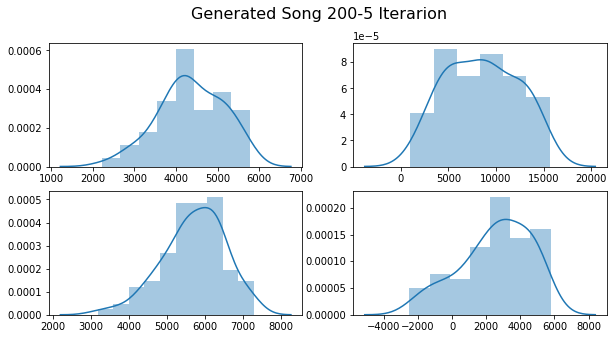

In [274]:
gen_song_both_complex_200_5 = crnngan_vanilla_both_complex.generated_songs[200][5].cpu().numpy()
fig, axs = plt.subplots(2, 2, figsize=(10,5))
fig.suptitle('Generated Song 200-5 Iterarion', fontsize=16)
sns.distplot(gen_song_both_complex_200_5[:,0], ax=axs[0, 0])
sns.distplot(gen_song_both_complex_200_5[:,1], ax=axs[0, 1])
sns.distplot(gen_song_both_complex_200_5[:,2], ax=axs[1, 0])
sns.distplot(gen_song_both_complex_200_5[:,3], ax=axs[1, 1])

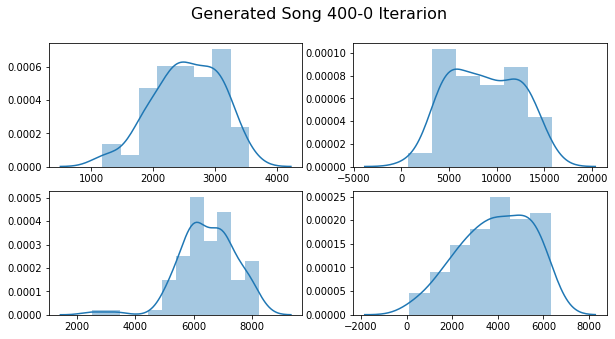

In [275]:
gen_song_both_complex_400_0 = crnngan_vanilla_both_complex.generated_songs[400][0].cpu().numpy()
fig, axs = plt.subplots(2, 2, figsize=(10,5))
fig.suptitle('Generated Song 400-0 Iterarion', fontsize=16)
sns.distplot(gen_song_both_complex_400_0[:,0], ax=axs[0, 0])
sns.distplot(gen_song_both_complex_400_0[:,1], ax=axs[0, 1])
sns.distplot(gen_song_both_complex_400_0[:,2], ax=axs[1, 0])
sns.distplot(gen_song_both_complex_400_0[:,3], ax=axs[1, 1])

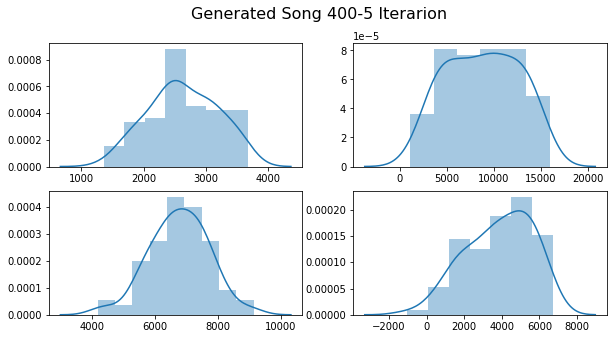

In [293]:
gen_song_both_complex_400_5 = crnngan_vanilla_both_complex.generated_songs[400][5].cpu().numpy()
fig, axs = plt.subplots(2, 2, figsize=(10,5))
fig.suptitle('Generated Song 400-5 Iterarion', fontsize=16)
sns.distplot(gen_song_both_complex_400_5[:,0], ax=axs[0, 0])
sns.distplot(gen_song_both_complex_400_5[:,1], ax=axs[0, 1])
sns.distplot(gen_song_both_complex_400_5[:,2], ax=axs[1, 0])
sns.distplot(gen_song_both_complex_400_5[:,3], ax=axs[1, 1])

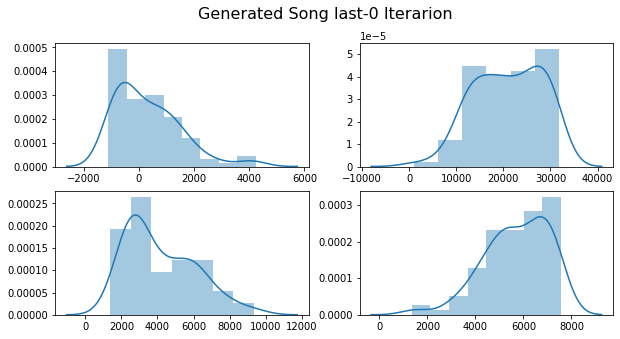

In [292]:
gen_song_both_complex_last = crnngan_vanilla_both_complex.generated_songs[-1][0].cpu().numpy()
fig, axs = plt.subplots(2, 2, figsize=(10,5))
fig.suptitle('Generated Song last-0 Iterarion', fontsize=16)
sns.distplot(gen_song_both_complex_last[:,0], ax=axs[0, 0])
sns.distplot(gen_song_both_complex_last[:,1], ax=axs[0, 1])
sns.distplot(gen_song_both_complex_last[:,2], ax=axs[1, 0])
sns.distplot(gen_song_both_complex_last[:,3], ax=axs[1, 1])

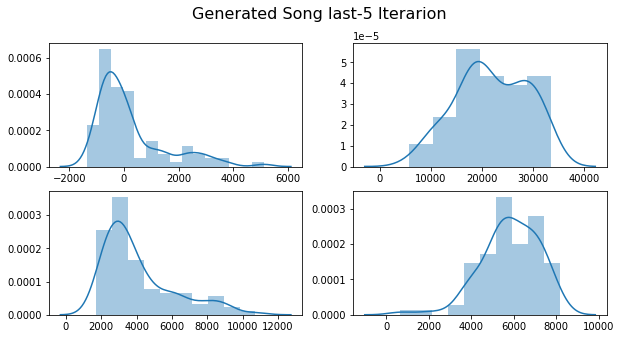

In [291]:
gen_song_both_complex_last_5 = crnngan_vanilla_both_complex.generated_songs[-1][5].cpu().numpy()
fig, axs = plt.subplots(2, 2, figsize=(10,5))
fig.suptitle('Generated Song last-5 Iterarion', fontsize=16)
sns.distplot(gen_song_both_complex_last_5[:,0], ax=axs[0, 0])
sns.distplot(gen_song_both_complex_last_5[:,1], ax=axs[0, 1])
sns.distplot(gen_song_both_complex_last_5[:,2], ax=axs[1, 0])
sns.distplot(gen_song_both_complex_last_5[:,3], ax=axs[1, 1])

As can be noted, this version is quite bad, we'll try to improve by modifying the deepness.

In [306]:
# Data loader
batch_length = 100
sequence_length = 100
# Generator parameters
in_channels_g = 20
out_channels_g = 4
hidden_dim_g = 350
n_layers_g = 2
# Discriminator parameters
in_channels_d = 4
out_channels_d = 2
hidden_dim_d = 350
n_layers_d = 3
# General
epochs = 50
curriculum_learning = False
complexDiscriminator = True
complexGenerator = True

crnngan_vanilla_both_complex_deep_discriminator = crnngan.CRNNGAN(batch_length, sequence_length,
                 in_channels_g, out_channels_g, hidden_dim_g, n_layers_g,
                 in_channels_d, out_channels_d, hidden_dim_d, n_layers_d,
                 curriculum_learning = curriculum_learning, epochs=epochs,
                 complexDiscriminator=complexDiscriminator, complexGenerator=complexGenerator)

cuda
Complex Generator
Complex Discriminator


In [307]:
crnngan_vanilla_both_complex_deep_discriminator.trainloop(musicDataLoader)

Start training for 50 epochs
[0/50][0]	Loss_D: 9.2112	Loss_G: 28.3512	D(x): -4.5995	D(G(z)): -4.6043 / 0.0000
 Time since epoch started: 0.18
There are a total of 0 fake songs saved already
[0/50][10]	Loss_D: 20.1878	Loss_G: 17.0130	D(x): -1.4610	D(G(z)): -1.4512 / -2.2909
 Time since epoch started: 1.86
There are a total of 5 fake songs saved already
[0/50][20]	Loss_D: 4.7170	Loss_G: 3.7739	D(x): -0.1205	D(G(z)): -0.1205 / -2.3606
 Time since epoch started: 3.55
There are a total of 10 fake songs saved already
Epoch time: 4.40
[1/50][30]	Loss_D: 4.5660	Loss_G: 2.1217	D(x): -2.0907	D(G(z)): -2.0820 / -0.0543
 Time since epoch started: 0.85
There are a total of 15 fake songs saved already
[1/50][40]	Loss_D: 4.4988	Loss_G: 5.9583	D(x): -1.0248	D(G(z)): -1.0248 / -0.0000
 Time since epoch started: 2.54
There are a total of 20 fake songs saved already
[1/50][50]	Loss_D: 4.1275	Loss_G: 2.4904	D(x): -0.5093	D(G(z)): -0.5091 / -0.0123
 Time since epoch started: 4.22
There are a total of 25 fa

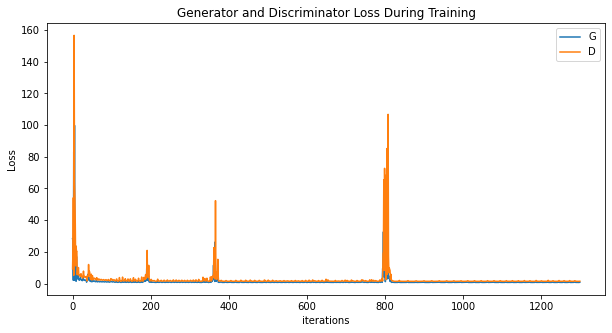

In [308]:
crnngan_vanilla_both_complex_deep_discriminator.plot_losses()

In [0]:
seq_length = 100
batch_length = 100
musicDataLoader.rewind('train')
_, batch_data = musicDataLoader.get_batch(batchsize=batch_length, songlength=seq_length)

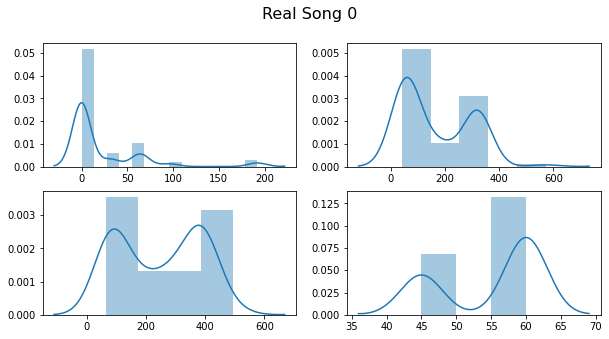

In [310]:
fig, axs = plt.subplots(2, 2, figsize=(10,5))
fig.suptitle('Real Song 0 ', fontsize=16)
sns.distplot(batch_data[0,:,0], ax=axs[0, 0])
sns.distplot(batch_data[0,:,1], ax=axs[0, 1])
sns.distplot(batch_data[0,:,2], ax=axs[1, 0])
sns.distplot(batch_data[0,:,3], ax=axs[1, 1])

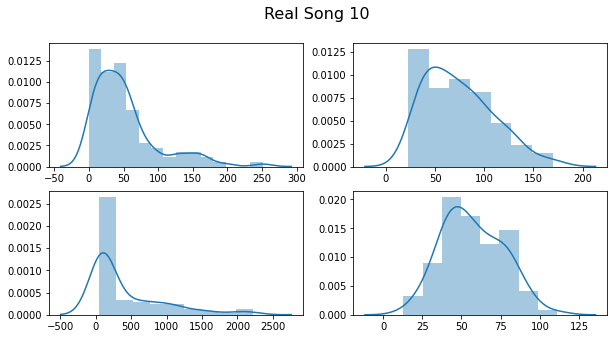

In [311]:
fig, axs = plt.subplots(2, 2, figsize=(10,5))
fig.suptitle('Real Song 10 ', fontsize=16)
sns.distplot(batch_data[10,:,0], ax=axs[0, 0])
sns.distplot(batch_data[10,:,1], ax=axs[0, 1])
sns.distplot(batch_data[10,:,2], ax=axs[1, 0])
sns.distplot(batch_data[10,:,3], ax=axs[1, 1])

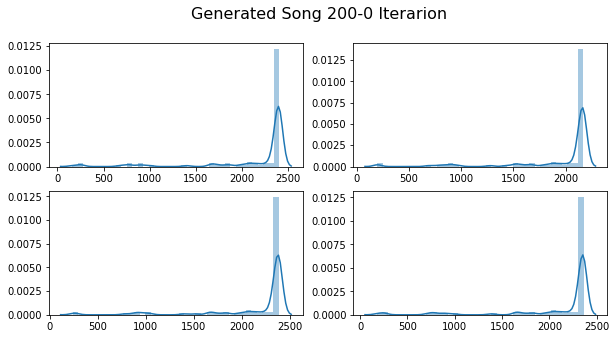

In [312]:
gen_song_both_complex_200_0_deep_discriminator = crnngan_vanilla_both_complex_deep_discriminator.generated_songs[200][0].cpu().numpy()
fig, axs = plt.subplots(2, 2, figsize=(10,5))
fig.suptitle('Generated Song 200-0 Iterarion', fontsize=16)
sns.distplot(gen_song_both_complex_200_0_deep_discriminator[:,0], ax=axs[0, 0])
sns.distplot(gen_song_both_complex_200_0_deep_discriminator[:,1], ax=axs[0, 1])
sns.distplot(gen_song_both_complex_200_0_deep_discriminator[:,2], ax=axs[1, 0])
sns.distplot(gen_song_both_complex_200_0_deep_discriminator[:,3], ax=axs[1, 1])

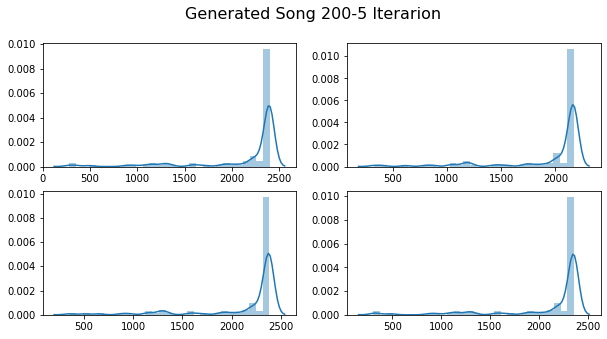

In [313]:
gen_song_both_complex_200_5_deep_discriminator = crnngan_vanilla_both_complex_deep_discriminator.generated_songs[200][5].cpu().numpy()
fig, axs = plt.subplots(2, 2, figsize=(10,5))
fig.suptitle('Generated Song 200-5 Iterarion', fontsize=16)
sns.distplot(gen_song_both_complex_200_5_deep_discriminator[:,0], ax=axs[0, 0])
sns.distplot(gen_song_both_complex_200_5_deep_discriminator[:,1], ax=axs[0, 1])
sns.distplot(gen_song_both_complex_200_5_deep_discriminator[:,2], ax=axs[1, 0])
sns.distplot(gen_song_both_complex_200_5_deep_discriminator[:,3], ax=axs[1, 1])

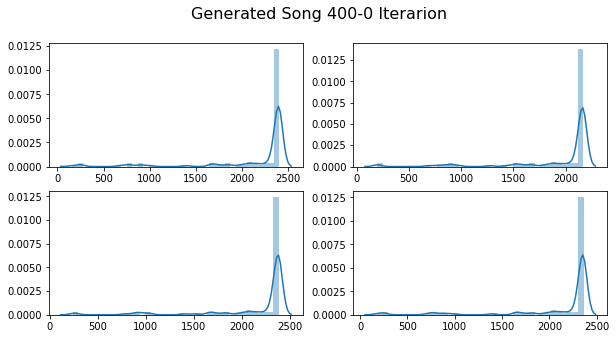

In [314]:
gen_song_both_complex_400_0_deep_discriminator = crnngan_vanilla_both_complex_deep_discriminator.generated_songs[400][0].cpu().numpy()
fig, axs = plt.subplots(2, 2, figsize=(10,5))
fig.suptitle('Generated Song 400-0 Iterarion', fontsize=16)
sns.distplot(gen_song_both_complex_400_0_deep_discriminator[:,0], ax=axs[0, 0])
sns.distplot(gen_song_both_complex_400_0_deep_discriminator[:,1], ax=axs[0, 1])
sns.distplot(gen_song_both_complex_400_0_deep_discriminator[:,2], ax=axs[1, 0])
sns.distplot(gen_song_both_complex_400_0_deep_discriminator[:,3], ax=axs[1, 1])

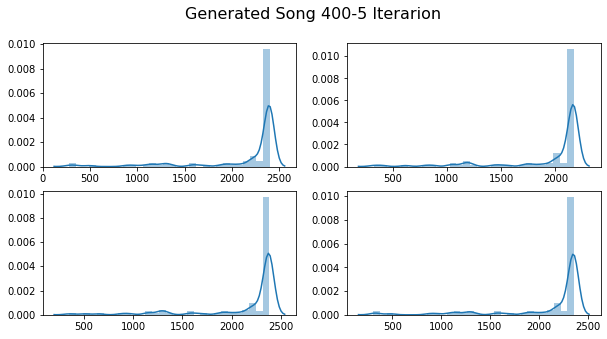

In [315]:
gen_song_both_complex_400_5_deep_discriminator = crnngan_vanilla_both_complex_deep_discriminator.generated_songs[400][5].cpu().numpy()
fig, axs = plt.subplots(2, 2, figsize=(10,5))
fig.suptitle('Generated Song 400-5 Iterarion', fontsize=16)
sns.distplot(gen_song_both_complex_400_5_deep_discriminator[:,0], ax=axs[0, 0])
sns.distplot(gen_song_both_complex_400_5_deep_discriminator[:,1], ax=axs[0, 1])
sns.distplot(gen_song_both_complex_400_5_deep_discriminator[:,2], ax=axs[1, 0])
sns.distplot(gen_song_both_complex_400_5_deep_discriminator[:,3], ax=axs[1, 1])

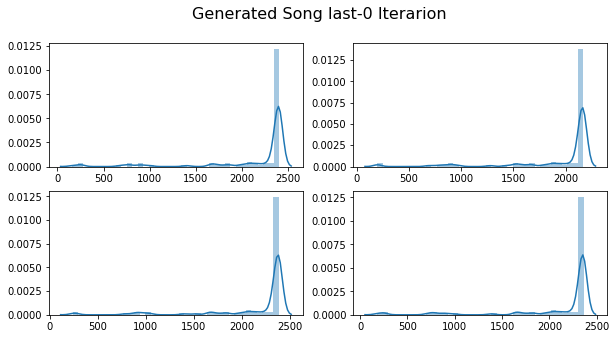

In [316]:
gen_song_both_complex_last_deep_discriminator = crnngan_vanilla_both_complex_deep_discriminator.generated_songs[-1][0].cpu().numpy()
fig, axs = plt.subplots(2, 2, figsize=(10,5))
fig.suptitle('Generated Song last-0 Iterarion', fontsize=16)
sns.distplot(gen_song_both_complex_last_deep_discriminator[:,0], ax=axs[0, 0])
sns.distplot(gen_song_both_complex_last_deep_discriminator[:,1], ax=axs[0, 1])
sns.distplot(gen_song_both_complex_last_deep_discriminator[:,2], ax=axs[1, 0])
sns.distplot(gen_song_both_complex_last_deep_discriminator[:,3], ax=axs[1, 1])

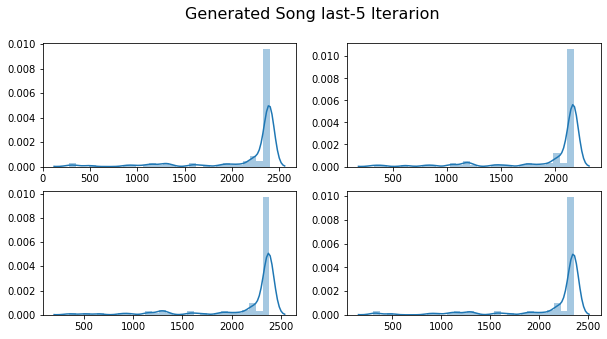

In [317]:
gen_song_both_complex_last_5_deep_discriminator = crnngan_vanilla_both_complex_deep_discriminator.generated_songs[-1][5].cpu().numpy()
fig, axs = plt.subplots(2, 2, figsize=(10,5))
fig.suptitle('Generated Song last-5 Iterarion', fontsize=16)
sns.distplot(gen_song_both_complex_last_5_deep_discriminator[:,0], ax=axs[0, 0])
sns.distplot(gen_song_both_complex_last_5_deep_discriminator[:,1], ax=axs[0, 1])
sns.distplot(gen_song_both_complex_last_5_deep_discriminator[:,2], ax=axs[1, 0])
sns.distplot(gen_song_both_complex_last_5_deep_discriminator[:,3], ax=axs[1, 1])

In [318]:
# Data loader
batch_length = 100
sequence_length = 100
# Generator parameters
in_channels_g = 20
out_channels_g = 4
hidden_dim_g = 350
n_layers_g = 3
# Discriminator parameters
in_channels_d = 4
out_channels_d = 2
hidden_dim_d = 350
n_layers_d = 2
# General
epochs = 50
curriculum_learning = False
complexDiscriminator = True
complexGenerator = True

crnngan_vanilla_both_complex_deep_generator = crnngan.CRNNGAN(batch_length, sequence_length,
                 in_channels_g, out_channels_g, hidden_dim_g, n_layers_g,
                 in_channels_d, out_channels_d, hidden_dim_d, n_layers_d,
                 curriculum_learning = curriculum_learning, epochs=epochs,
                 complexDiscriminator=complexDiscriminator, complexGenerator=complexGenerator)

cuda
Complex Generator
Complex Discriminator


In [319]:
crnngan_vanilla_both_complex_deep_generator.trainloop(musicDataLoader)

Start training for 50 epochs
[0/50][0]	Loss_D: 9.2074	Loss_G: 29.1035	D(x): -4.5768	D(G(z)): -4.6051 / 0.0000
 Time since epoch started: 0.17
There are a total of 0 fake songs saved already
[0/50][10]	Loss_D: 0.0565	Loss_G: 15.6249	D(x): -0.0545	D(G(z)): -0.0019 / -0.0012
 Time since epoch started: 1.72
There are a total of 5 fake songs saved already
[0/50][20]	Loss_D: 0.0004	Loss_G: 17.2830	D(x): -0.0002	D(G(z)): -0.0002 / -0.0002
 Time since epoch started: 3.26
There are a total of 10 fake songs saved already
Epoch time: 4.04
[1/50][30]	Loss_D: 0.0001	Loss_G: 22.6359	D(x): 0.0000	D(G(z)): -0.0001 / -0.0001
 Time since epoch started: 0.77
There are a total of 15 fake songs saved already
[1/50][40]	Loss_D: 0.0000	Loss_G: 26.7514	D(x): 0.0000	D(G(z)): -0.0000 / -0.0000
 Time since epoch started: 2.31
There are a total of 20 fake songs saved already
[1/50][50]	Loss_D: 0.0000	Loss_G: 28.7905	D(x): -0.0000	D(G(z)): -0.0000 / -0.0000
 Time since epoch started: 3.85
There are a total of 25 f

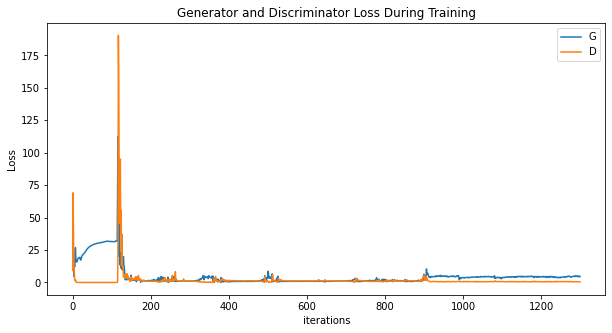

In [329]:
crnngan_vanilla_both_complex_deep_generator.plot_losses()

In [0]:
seq_length = 100
batch_length = 100
musicDataLoader.rewind('train')
_, batch_data = musicDataLoader.get_batch(batchsize=batch_length, songlength=seq_length)

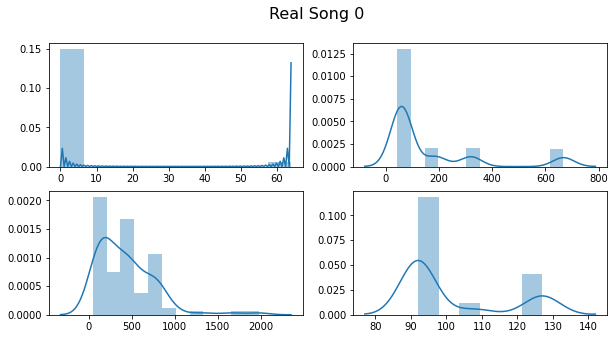

In [321]:
fig, axs = plt.subplots(2, 2, figsize=(10,5))
fig.suptitle('Real Song 0 ', fontsize=16)
sns.distplot(batch_data[0,:,0], ax=axs[0, 0])
sns.distplot(batch_data[0,:,1], ax=axs[0, 1])
sns.distplot(batch_data[0,:,2], ax=axs[1, 0])
sns.distplot(batch_data[0,:,3], ax=axs[1, 1])

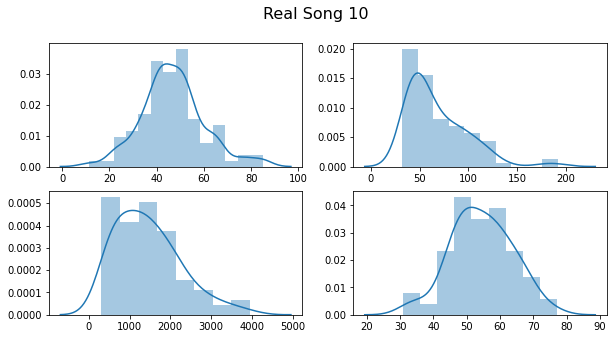

In [322]:
fig, axs = plt.subplots(2, 2, figsize=(10,5))
fig.suptitle('Real Song 10 ', fontsize=16)
sns.distplot(batch_data[10,:,0], ax=axs[0, 0])
sns.distplot(batch_data[10,:,1], ax=axs[0, 1])
sns.distplot(batch_data[10,:,2], ax=axs[1, 0])
sns.distplot(batch_data[10,:,3], ax=axs[1, 1])

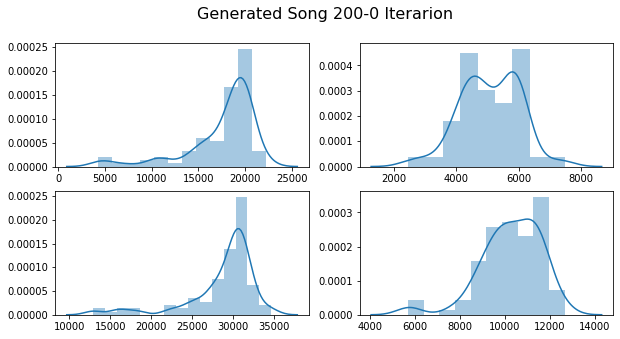

In [323]:
gen_song_both_complex_200_0_deep_generator = crnngan_vanilla_both_complex_deep_generator.generated_songs[200][0].cpu().numpy()
fig, axs = plt.subplots(2, 2, figsize=(10,5))
fig.suptitle('Generated Song 200-0 Iterarion', fontsize=16)
sns.distplot(gen_song_both_complex_200_0_deep_generator[:,0], ax=axs[0, 0])
sns.distplot(gen_song_both_complex_200_0_deep_generator[:,1], ax=axs[0, 1])
sns.distplot(gen_song_both_complex_200_0_deep_generator[:,2], ax=axs[1, 0])
sns.distplot(gen_song_both_complex_200_0_deep_generator[:,3], ax=axs[1, 1])

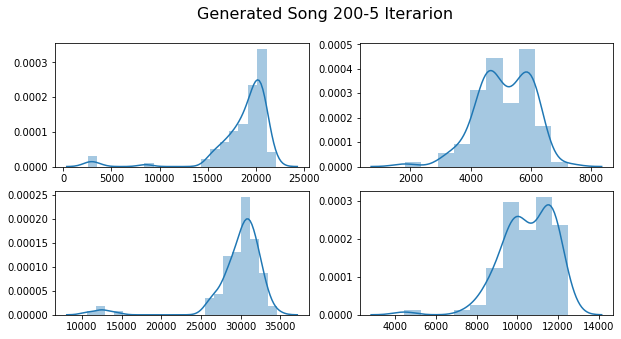

In [324]:
gen_song_both_complex_200_5_deep_generator = crnngan_vanilla_both_complex_deep_generator.generated_songs[200][5].cpu().numpy()
fig, axs = plt.subplots(2, 2, figsize=(10,5))
fig.suptitle('Generated Song 200-5 Iterarion', fontsize=16)
sns.distplot(gen_song_both_complex_200_5_deep_generator[:,0], ax=axs[0, 0])
sns.distplot(gen_song_both_complex_200_5_deep_generator[:,1], ax=axs[0, 1])
sns.distplot(gen_song_both_complex_200_5_deep_generator[:,2], ax=axs[1, 0])
sns.distplot(gen_song_both_complex_200_5_deep_generator[:,3], ax=axs[1, 1])

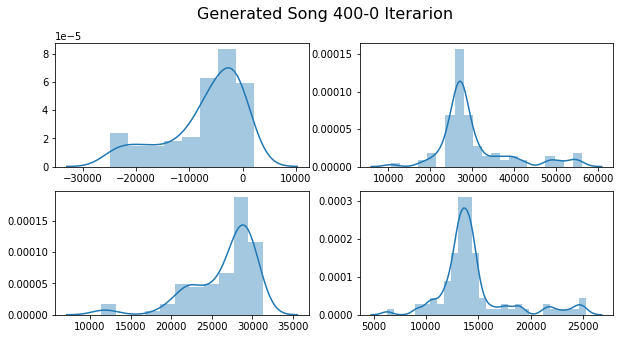

In [325]:
gen_song_both_complex_400_0_deep_generator = crnngan_vanilla_both_complex_deep_generator.generated_songs[400][0].cpu().numpy()
fig, axs = plt.subplots(2, 2, figsize=(10,5))
fig.suptitle('Generated Song 400-0 Iterarion', fontsize=16)
sns.distplot(gen_song_both_complex_400_0_deep_generator[:,0], ax=axs[0, 0])
sns.distplot(gen_song_both_complex_400_0_deep_generator[:,1], ax=axs[0, 1])
sns.distplot(gen_song_both_complex_400_0_deep_generator[:,2], ax=axs[1, 0])
sns.distplot(gen_song_both_complex_400_0_deep_generator[:,3], ax=axs[1, 1])

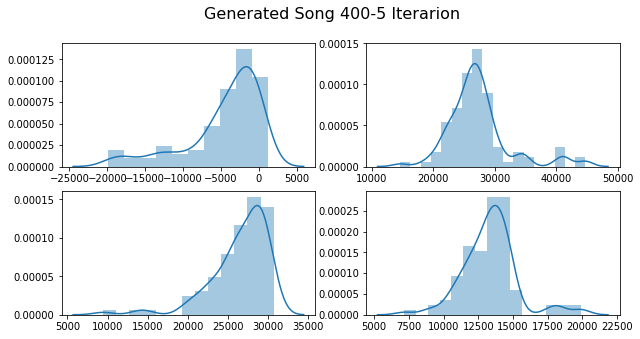

In [326]:
gen_song_both_complex_400_5_deep_generator = crnngan_vanilla_both_complex_deep_generator.generated_songs[400][5].cpu().numpy()
fig, axs = plt.subplots(2, 2, figsize=(10,5))
fig.suptitle('Generated Song 400-5 Iterarion', fontsize=16)
sns.distplot(gen_song_both_complex_400_5_deep_generator[:,0], ax=axs[0, 0])
sns.distplot(gen_song_both_complex_400_5_deep_generator[:,1], ax=axs[0, 1])
sns.distplot(gen_song_both_complex_400_5_deep_generator[:,2], ax=axs[1, 0])
sns.distplot(gen_song_both_complex_400_5_deep_generator[:,3], ax=axs[1, 1])

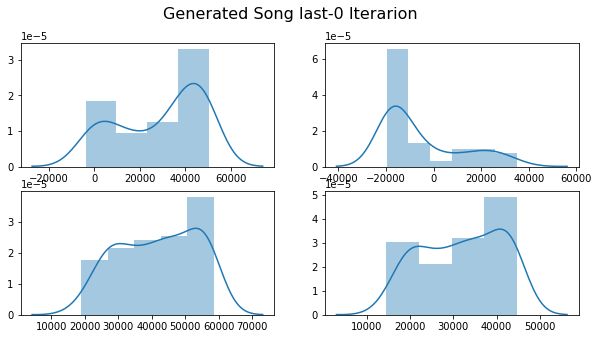

In [327]:
gen_song_both_complex_last_deep_generator = crnngan_vanilla_both_complex_deep_generator.generated_songs[-1][0].cpu().numpy()
fig, axs = plt.subplots(2, 2, figsize=(10,5))
fig.suptitle('Generated Song last-0 Iterarion', fontsize=16)
sns.distplot(gen_song_both_complex_last_deep_generator[:,0], ax=axs[0, 0])
sns.distplot(gen_song_both_complex_last_deep_generator[:,1], ax=axs[0, 1])
sns.distplot(gen_song_both_complex_last_deep_generator[:,2], ax=axs[1, 0])
sns.distplot(gen_song_both_complex_last_deep_generator[:,3], ax=axs[1, 1])

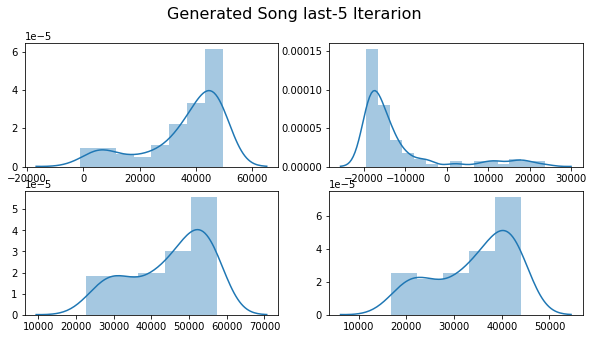

In [328]:
gen_song_both_complex_last_5_deep_generator = crnngan_vanilla_both_complex_deep_generator.generated_songs[-1][5].cpu().numpy()
fig, axs = plt.subplots(2, 2, figsize=(10,5))
fig.suptitle('Generated Song last-5 Iterarion', fontsize=16)
sns.distplot(gen_song_both_complex_last_5_deep_generator[:,0], ax=axs[0, 0])
sns.distplot(gen_song_both_complex_last_5_deep_generator[:,1], ax=axs[0, 1])
sns.distplot(gen_song_both_complex_last_5_deep_generator[:,2], ax=axs[1, 0])
sns.distplot(gen_song_both_complex_last_5_deep_generator[:,3], ax=axs[1, 1])

Very saturated.

In [342]:
# Data loader
batch_length = 100
sequence_length = 100
# Generator parameters
in_channels_g = 20
out_channels_g = 4
hidden_dim_g = 350
n_layers_g = 3
# Discriminator parameters
in_channels_d = 4
out_channels_d = 2
hidden_dim_d = 350
n_layers_d = 3
# General
epochs = 50
curriculum_learning = False
complexDiscriminator = True
complexGenerator = True

crnngan_vanilla_both_complex_both_deep = crnngan.CRNNGAN(batch_length, sequence_length,
                 in_channels_g, out_channels_g, hidden_dim_g, n_layers_g,
                 in_channels_d, out_channels_d, hidden_dim_d, n_layers_d,
                 curriculum_learning = curriculum_learning, epochs=epochs,
                 complexDiscriminator=complexDiscriminator, complexGenerator=complexGenerator)

cuda
Complex Generator
Complex Discriminator


In [343]:
crnngan_vanilla_both_complex_both_deep.trainloop(musicDataLoader)

Start training for 50 epochs
[0/50][0]	Loss_D: 9.2039	Loss_G: 23.4522	D(x): -4.5974	D(G(z)): -4.6040 / 0.0000
 Time since epoch started: 0.20
There are a total of 0 fake songs saved already
[0/50][10]	Loss_D: 5.1891	Loss_G: 2.7004	D(x): -1.0604	D(G(z)): -1.0604 / -0.3685
 Time since epoch started: 2.06
There are a total of 5 fake songs saved already
[0/50][20]	Loss_D: 3.4907	Loss_G: 1.3987	D(x): -0.8587	D(G(z)): -0.8587 / -0.6416
 Time since epoch started: 3.92
There are a total of 10 fake songs saved already
Epoch time: 4.84
[1/50][30]	Loss_D: 2.1900	Loss_G: 0.8920	D(x): -0.8223	D(G(z)): -0.8223 / -0.3828
 Time since epoch started: 0.94
There are a total of 15 fake songs saved already
[1/50][40]	Loss_D: 4.2314	Loss_G: 1.2701	D(x): -0.0895	D(G(z)): -0.0895 / -0.0993
 Time since epoch started: 2.80
There are a total of 20 fake songs saved already
[1/50][50]	Loss_D: 1.4411	Loss_G: 0.7146	D(x): -0.7139	D(G(z)): -0.7139 / -0.6996
 Time since epoch started: 4.65
There are a total of 25 fake

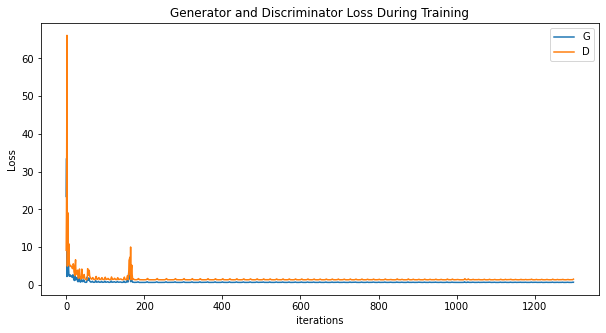

In [344]:
crnngan_vanilla_both_complex_both_deep.plot_losses()

In [0]:
seq_length = 100
batch_length = 100
musicDataLoader.rewind('train')
_, batch_data = musicDataLoader.get_batch(batchsize=batch_length, songlength=seq_length)

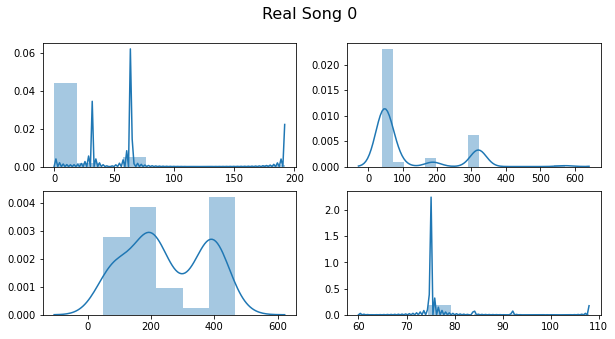

In [346]:
fig, axs = plt.subplots(2, 2, figsize=(10,5))
fig.suptitle('Real Song 0 ', fontsize=16)
sns.distplot(batch_data[0,:,0], ax=axs[0, 0])
sns.distplot(batch_data[0,:,1], ax=axs[0, 1])
sns.distplot(batch_data[0,:,2], ax=axs[1, 0])
sns.distplot(batch_data[0,:,3], ax=axs[1, 1])

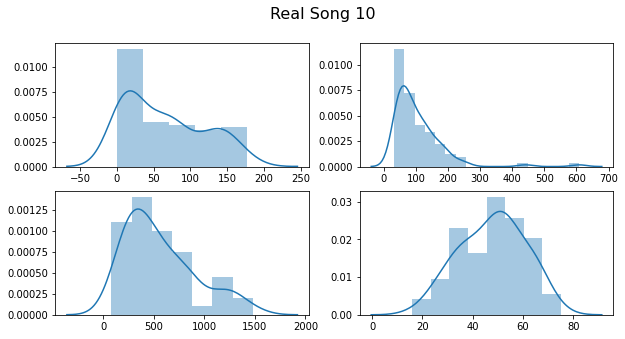

In [347]:
fig, axs = plt.subplots(2, 2, figsize=(10,5))
fig.suptitle('Real Song 10 ', fontsize=16)
sns.distplot(batch_data[10,:,0], ax=axs[0, 0])
sns.distplot(batch_data[10,:,1], ax=axs[0, 1])
sns.distplot(batch_data[10,:,2], ax=axs[1, 0])
sns.distplot(batch_data[10,:,3], ax=axs[1, 1])

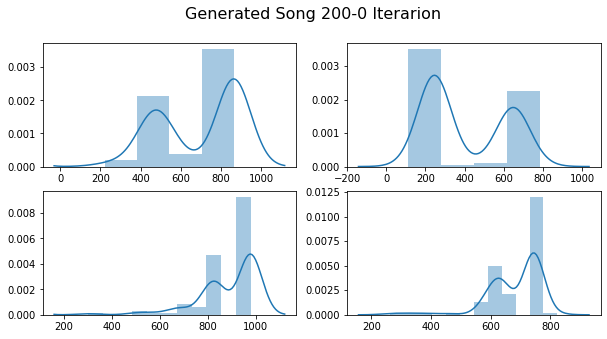

In [348]:
gen_song_both_complex_200_0_both_deep = crnngan_vanilla_both_complex_both_deep.generated_songs[200][0].cpu().numpy()
fig, axs = plt.subplots(2, 2, figsize=(10,5))
fig.suptitle('Generated Song 200-0 Iterarion', fontsize=16)
sns.distplot(gen_song_both_complex_200_0_both_deep[:,0], ax=axs[0, 0])
sns.distplot(gen_song_both_complex_200_0_both_deep[:,1], ax=axs[0, 1])
sns.distplot(gen_song_both_complex_200_0_both_deep[:,2], ax=axs[1, 0])
sns.distplot(gen_song_both_complex_200_0_both_deep[:,3], ax=axs[1, 1])

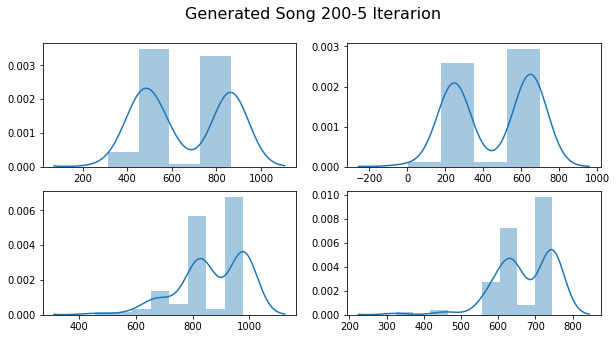

In [349]:
gen_song_both_complex_200_5_both_deep = crnngan_vanilla_both_complex_both_deep.generated_songs[200][5].cpu().numpy()
fig, axs = plt.subplots(2, 2, figsize=(10,5))
fig.suptitle('Generated Song 200-5 Iterarion', fontsize=16)
sns.distplot(gen_song_both_complex_200_5_both_deep[:,0], ax=axs[0, 0])
sns.distplot(gen_song_both_complex_200_5_both_deep[:,1], ax=axs[0, 1])
sns.distplot(gen_song_both_complex_200_5_both_deep[:,2], ax=axs[1, 0])
sns.distplot(gen_song_both_complex_200_5_both_deep[:,3], ax=axs[1, 1])

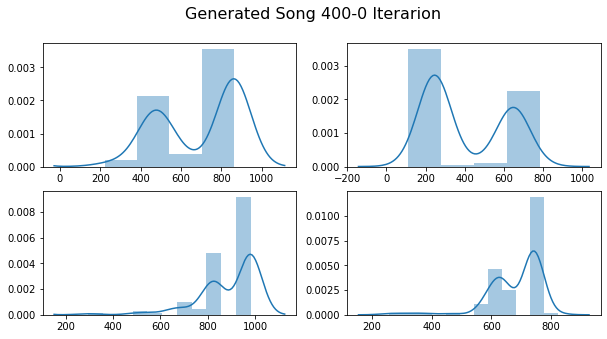

In [350]:
gen_song_both_complex_400_0_both_deep = crnngan_vanilla_both_complex_both_deep.generated_songs[400][0].cpu().numpy()
fig, axs = plt.subplots(2, 2, figsize=(10,5))
fig.suptitle('Generated Song 400-0 Iterarion', fontsize=16)
sns.distplot(gen_song_both_complex_400_0_both_deep[:,0], ax=axs[0, 0])
sns.distplot(gen_song_both_complex_400_0_both_deep[:,1], ax=axs[0, 1])
sns.distplot(gen_song_both_complex_400_0_both_deep[:,2], ax=axs[1, 0])
sns.distplot(gen_song_both_complex_400_0_both_deep[:,3], ax=axs[1, 1])

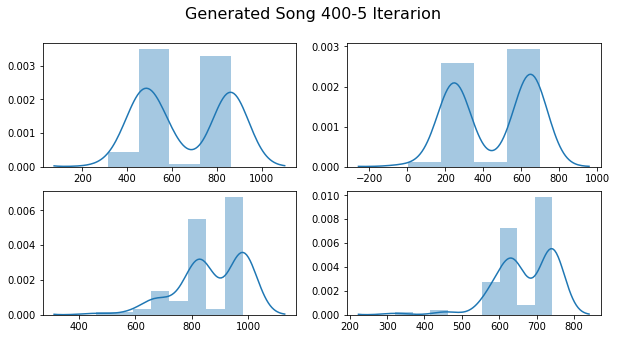

In [351]:
gen_song_both_complex_400_5_both_deep = crnngan_vanilla_both_complex_both_deep.generated_songs[400][5].cpu().numpy()
fig, axs = plt.subplots(2, 2, figsize=(10,5))
fig.suptitle('Generated Song 400-5 Iterarion', fontsize=16)
sns.distplot(gen_song_both_complex_400_5_both_deep[:,0], ax=axs[0, 0])
sns.distplot(gen_song_both_complex_400_5_both_deep[:,1], ax=axs[0, 1])
sns.distplot(gen_song_both_complex_400_5_both_deep[:,2], ax=axs[1, 0])
sns.distplot(gen_song_both_complex_400_5_both_deep[:,3], ax=axs[1, 1])

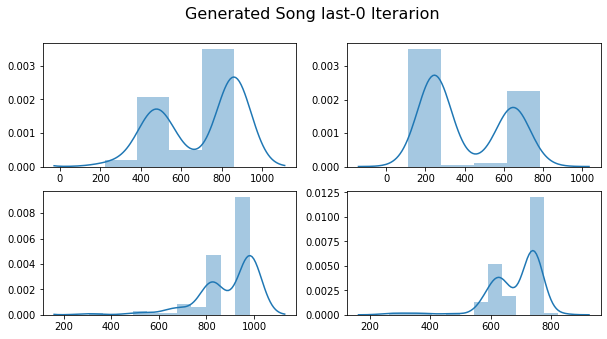

In [352]:
gen_song_both_complex_last_both_deep = crnngan_vanilla_both_complex_both_deep.generated_songs[-1][0].cpu().numpy()
fig, axs = plt.subplots(2, 2, figsize=(10,5))
fig.suptitle('Generated Song last-0 Iterarion', fontsize=16)
sns.distplot(gen_song_both_complex_last_both_deep[:,0], ax=axs[0, 0])
sns.distplot(gen_song_both_complex_last_both_deep[:,1], ax=axs[0, 1])
sns.distplot(gen_song_both_complex_last_both_deep[:,2], ax=axs[1, 0])
sns.distplot(gen_song_both_complex_last_both_deep[:,3], ax=axs[1, 1])

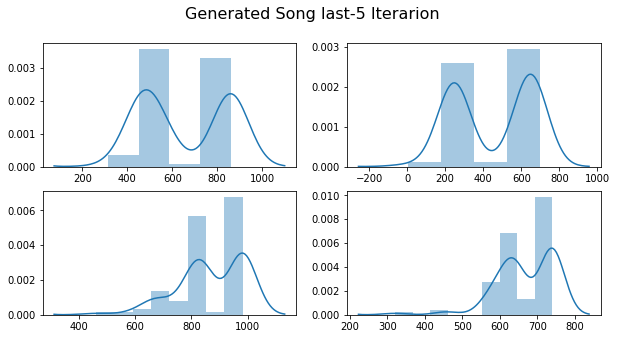

In [353]:
gen_song_both_complex_last_5_both_deep = crnngan_vanilla_both_complex_both_deep.generated_songs[-1][5].cpu().numpy()
fig, axs = plt.subplots(2, 2, figsize=(10,5))
fig.suptitle('Generated Song last-5 Iterarion', fontsize=16)
sns.distplot(gen_song_both_complex_last_5_both_deep[:,0], ax=axs[0, 0])
sns.distplot(gen_song_both_complex_last_5_both_deep[:,1], ax=axs[0, 1])
sns.distplot(gen_song_both_complex_last_5_both_deep[:,2], ax=axs[1, 0])
sns.distplot(gen_song_both_complex_last_5_both_deep[:,3], ax=axs[1, 1])

Doesn't look very good...

From this we could go onto curriculum learning and ty the same configurations as we've tried here.
Then we can think about seeing how good or bad normalization is.